In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC
from sklearn.utils import resample,shuffle
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_predict, train_test_split, cross_val_score
import matplotlib.pyplot as plt
#from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense
from sklearn import metrics
import seaborn as sb
import os
import pickle
import urllib.request
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

In [2]:
#retrieve dataset from google drive
urllib.request.urlretrieve('https://drive.google.com/uc?id=1Rj9lVcyfGhIf972I-g4Yo8x09RCqmC-9&export=download','covid.csv')

('covid.csv', <http.client.HTTPMessage at 0x7f1ace1dded0>)

# Data Cleaning and Visualization

In [3]:
data = pd.read_csv('covid.csv')
data

,id,sex,patient_type,entry_date,date_symptoms,date_died,intubed,pneumonia,age,pregnancy,diabetes,copd,asthma,inmsupr,hypertension,other_disease,cardiovascular,obesity,renal_chronic,tobacco,contact_other_covid,covid_res,icu
0,16169f,2,1,04-05-2020,02-05-2020,9999-99-99,97,2,27,97,2,2,2,2,2,2,2,2,2,2,2,1,97
1,1009bf,2,1,19-03-2020,17-03-2020,9999-99-99,97,2,24,97,2,2,2,2,2,2,2,2,2,2,99,1,97
2,167386,1,2,06-04-2020,01-04-2020,9999-99-99,2,2,54,2,2,2,2,2,2,2,2,1,2,2,99,1,2
3,0b5948,2,2,17-04-2020,10-04-2020,9999-99-99,2,1,30,97,2,2,2,2,2,2,2,2,2,2,99,1,2
4,0d01b5,1,2,13-04-2020,13-04-2020,22-04-2020,2,2,60,2,1,2,2,2,1,2,1,2,2,2,99,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
566597,01ff60,2,1,13-05-2020,03-05-2020,9999-99-99,97,2,58,97,1,2,2,2,2,2,2,2,2,2,2,3,97
566598,047cd1,1,1,07-04-2020,06-04-2020,9999-99-99,97,2,48,2,2,2,2,2,2,2,2,2,2,2,2,3,97
566599,1beb81,1,2,14-05-2020,01-05-2020,9999-99-99,2,1,49,2,2,2,2,2,2,2,2,1,2,2,99,3,2
566600,16fb02,1,1,31-05-2020,29-05-2020,9999-99-99,97,1,43,2,2,2,2,2,2,2,2,2,2,2,2,3,97


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 566602 entries, 0 to 566601
Data columns (total 23 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   id                   566602 non-null  object
 1   sex                  566602 non-null  int64 
 2   patient_type         566602 non-null  int64 
 3   entry_date           566602 non-null  object
 4   date_symptoms        566602 non-null  object
 5   date_died            566602 non-null  object
 6   intubed              566602 non-null  int64 
 7   pneumonia            566602 non-null  int64 
 8   age                  566602 non-null  int64 
 9   pregnancy            566602 non-null  int64 
 10  diabetes             566602 non-null  int64 
 11  copd                 566602 non-null  int64 
 12  asthma               566602 non-null  int64 
 13  inmsupr              566602 non-null  int64 
 14  hypertension         566602 non-null  int64 
 15  other_disease        566602 non-nu

In [5]:
#to check values of each columns
for column in data:
    print('{} : {}'.format(str(column),data[column].unique()))

id : ['16169f' '1009bf' '167386' ... '1beb81' '16fb02' '0021c9']
sex : [2 1]
patient_type : [1 2]
entry_date : ['04-05-2020' '19-03-2020' '06-04-2020' '17-04-2020' '13-04-2020'
 '16-04-2020' '22-04-2020' '21-05-2020' '23-04-2020' '29-04-2020'
 '02-05-2020' '25-05-2020' '07-06-2020' '20-06-2020' '24-06-2020'
 '30-04-2020' '05-05-2020' '12-05-2020' '19-04-2020' '02-06-2020'
 '25-04-2020' '15-05-2020' '27-04-2020' '01-04-2020' '22-06-2020'
 '21-04-2020' '24-04-2020' '20-04-2020' '28-04-2020' '26-04-2020'
 '19-06-2020' '31-03-2020' '03-04-2020' '14-04-2020' '12-04-2020'
 '29-03-2020' '06-05-2020' '11-06-2020' '10-06-2020' '02-04-2020'
 '19-05-2020' '05-06-2020' '17-06-2020' '10-04-2020' '03-05-2020'
 '16-06-2020' '30-03-2020' '15-04-2020' '08-06-2020' '15-06-2020'
 '25-03-2020' '25-06-2020' '08-04-2020' '27-05-2020' '20-05-2020'
 '01-06-2020' '18-06-2020' '07-05-2020' '08-05-2020' '29-05-2020'
 '07-04-2020' '11-04-2020' '23-03-2020' '11-05-2020' '18-04-2020'
 '17-05-2020' '22-05-2020' '05-

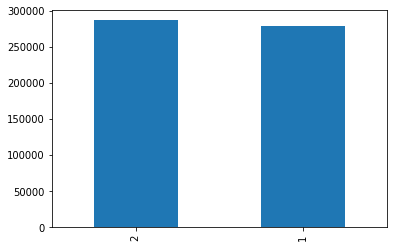

In [6]:
data.sex.value_counts().plot(kind='bar')

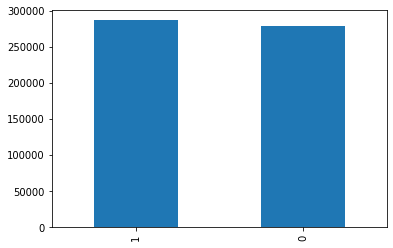

In [7]:
#converting to female : 0, male : 1
data['sex'] = data['sex'].apply(lambda x : x-1)
data.sex.value_counts().plot(kind='bar')

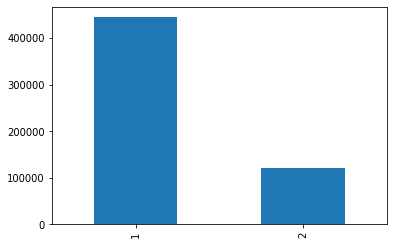

In [8]:
data.patient_type.value_counts().plot(kind='bar')

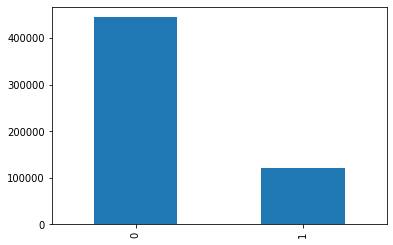

In [9]:
# converting to Outpatient : 0, Inpatient : 1 and changing name to hospitalized
data['hospitalized'] = data['patient_type'].apply(lambda x : x-1)
data.hospitalized.value_counts().plot(kind='bar')

In [10]:
data.date_died.value_counts()

9999-99-99    530426
08-06-2020       701
16-06-2020       699
10-06-2020       691
12-06-2020       674
               ...  
25-02-2020         1
26-02-2020         1
10-02-2020         1
11-02-2020         1
15-01-2020         1
Name: date_died, Length: 124, dtype: int64

In [11]:
#adding new dataframe of whether patient died or not
data['death'] = data['date_died'].apply(lambda x : 0 if x == '9999-99-99' else 1)
data

,id,sex,patient_type,entry_date,date_symptoms,date_died,intubed,pneumonia,age,pregnancy,diabetes,copd,asthma,inmsupr,hypertension,other_disease,cardiovascular,obesity,renal_chronic,tobacco,contact_other_covid,covid_res,icu,hospitalized,death
0,16169f,1,1,04-05-2020,02-05-2020,9999-99-99,97,2,27,97,2,2,2,2,2,2,2,2,2,2,2,1,97,0,0
1,1009bf,1,1,19-03-2020,17-03-2020,9999-99-99,97,2,24,97,2,2,2,2,2,2,2,2,2,2,99,1,97,0,0
2,167386,0,2,06-04-2020,01-04-2020,9999-99-99,2,2,54,2,2,2,2,2,2,2,2,1,2,2,99,1,2,1,0
3,0b5948,1,2,17-04-2020,10-04-2020,9999-99-99,2,1,30,97,2,2,2,2,2,2,2,2,2,2,99,1,2,1,0
4,0d01b5,0,2,13-04-2020,13-04-2020,22-04-2020,2,2,60,2,1,2,2,2,1,2,1,2,2,2,99,1,2,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
566597,01ff60,1,1,13-05-2020,03-05-2020,9999-99-99,97,2,58,97,1,2,2,2,2,2,2,2,2,2,2,3,97,0,0
566598,047cd1,0,1,07-04-2020,06-04-2020,9999-99-99,97,2,48,2,2,2,2,2,2,2,2,2,2,2,2,3,97,0,0
566599,1beb81,0,2,14-05-2020,01-05-2020,9999-99-99,2,1,49,2,2,2,2,2,2,2,2,1,2,2,99,3,2,1,0
566600,16fb02,0,1,31-05-2020,29-05-2020,9999-99-99,97,1,43,2,2,2,2,2,2,2,2,2,2,2,2,3,97,0,0


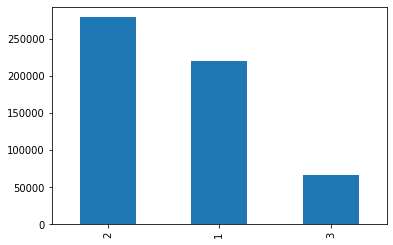

In [12]:
data.covid_res.value_counts().plot(kind='bar')

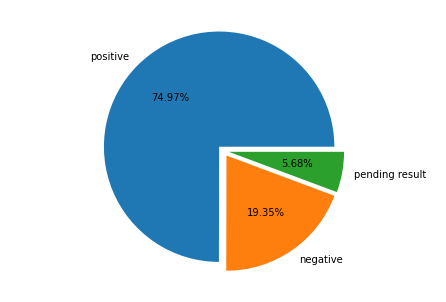

In [13]:
neg_death = []
pos_death = []
nores_death = []
for index, patient in data.iterrows():
    if patient['covid_res'] == 2 and patient['death'] == 1:
        neg_death.append(patient)
    if patient['covid_res'] == 1 and patient['death'] == 1:
        pos_death.append(patient)
    if patient['covid_res'] == 3 and patient['death'] == 1:
        nores_death.append(patient)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')
result = ['positive', 'negative', 'pending result']
deaths = [len(pos_death),len(neg_death),len(nores_death)]
ax.pie(deaths, labels = result,autopct='%1.2f%%', explode = [0.05, 0.05, 0.05])
plt.show()

In [14]:
#drop patients who are negative or no result came
positive_patients = data.drop(data[(data.covid_res == 2) | (data.covid_res == 3) ].index)

In [15]:
type(positive_patients['entry_date'][0])

str

In [16]:
# make new column of number of days after patient died
def calculateDays(start_date_str, end_date_str):
    start_date_obj = datetime.strptime(start_date_str, '%d-%m-%Y')
    end_date_obj = datetime.strptime(end_date_str, '%d-%m-%Y')
    days = end_date_obj - start_date_obj
    return days.days

In [17]:
positive_patients['days'] = positive_patients.apply(lambda x: calculateDays(x.entry_date,x.date_died) if x.death == 1 else -1, axis=1)

In [18]:
positive_patients

,id,sex,patient_type,entry_date,date_symptoms,date_died,intubed,pneumonia,age,pregnancy,diabetes,copd,asthma,inmsupr,hypertension,other_disease,cardiovascular,obesity,renal_chronic,tobacco,contact_other_covid,covid_res,icu,hospitalized,death,days
0,16169f,1,1,04-05-2020,02-05-2020,9999-99-99,97,2,27,97,2,2,2,2,2,2,2,2,2,2,2,1,97,0,0,-1
1,1009bf,1,1,19-03-2020,17-03-2020,9999-99-99,97,2,24,97,2,2,2,2,2,2,2,2,2,2,99,1,97,0,0,-1
2,167386,0,2,06-04-2020,01-04-2020,9999-99-99,2,2,54,2,2,2,2,2,2,2,2,1,2,2,99,1,2,1,0,-1
3,0b5948,1,2,17-04-2020,10-04-2020,9999-99-99,2,1,30,97,2,2,2,2,2,2,2,2,2,2,99,1,2,1,0,-1
4,0d01b5,0,2,13-04-2020,13-04-2020,22-04-2020,2,2,60,2,1,2,2,2,1,2,1,2,2,2,99,1,2,1,1,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220652,27424,0,2,10-06-2020,08-06-2020,10-06-2020,2,1,88,2,1,2,2,2,1,2,2,2,2,2,99,1,2,1,1,0
220653,12ed19,0,1,11-06-2020,01-06-2020,9999-99-99,97,2,30,2,2,2,2,2,2,2,2,2,2,2,99,1,97,0,0,-1
220654,6.60E+43,0,1,11-06-2020,10-06-2020,9999-99-99,97,2,27,2,2,2,2,2,2,2,2,2,2,2,2,1,97,0,0,-1
220655,09f931,0,1,19-06-2020,16-06-2020,9999-99-99,97,2,36,2,2,2,1,2,2,2,2,2,2,2,1,1,97,0,0,-1


In [19]:
positive_patients.describe()

,sex,patient_type,intubed,pneumonia,age,pregnancy,diabetes,copd,asthma,inmsupr,hypertension,other_disease,cardiovascular,obesity,renal_chronic,tobacco,contact_other_covid,covid_res,icu,hospitalized,death,days
count,220657.000000,220657.000000,220657.000000,220657.000000,220657.000000,220657.000000,220657.000000,220657.000000,220657.000000,220657.000000,220657.000000,220657.000000,220657.000000,220657.000000,220657.000000,220657.000000,220657.000000,220657.0,220657.000000,220657.000000,220657.000000,220657.000000
mean,0.547451,1.309512,67.604042,1.760987,45.688208,54.299016,2.206678,2.315254,2.308828,2.365708,2.147301,2.470980,2.335099,2.159483,2.324608,2.295314,37.281659,1.0,67.607776,0.309512,0.122910,0.016215
std,0.497744,0.462294,43.947997,0.557789,16.314227,47.266765,5.975469,5.645304,5.676047,6.024965,5.795873,6.910459,5.858890,5.856078,5.758677,5.981982,47.016224,0.0,43.942869,0.462294,0.328335,3.640110
min,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,0.000000,0.000000,-27.000000
25%,0.000000,1.000000,2.000000,2.000000,34.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.0,2.000000,0.000000,0.000000,-1.000000
50%,1.000000,1.000000,97.000000,2.000000,45.000000,97.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.0,97.000000,0.000000,0.000000,-1.000000
75%,1.000000,2.000000,97.000000,2.000000,57.000000,97.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,99.000000,1.0,97.000000,1.000000,0.000000,-1.000000
max,1.000000,2.000000,99.000000,99.000000,120.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,99.000000,1.0,99.000000,1.000000,1.000000,79.000000


In [20]:
positive_patients.loc[positive_patients['days'] < -1]

,id,sex,patient_type,entry_date,date_symptoms,date_died,intubed,pneumonia,age,pregnancy,diabetes,copd,asthma,inmsupr,hypertension,other_disease,cardiovascular,obesity,renal_chronic,tobacco,contact_other_covid,covid_res,icu,hospitalized,death,days
798,0e2e3e,1,1,04-05-2020,27-04-2020,01-05-2020,97,2,47,97,2,2,2,2,2,2,2,1,2,2,99,1,97,0,1,-3
4290,0f1e84,1,1,03-06-2020,23-05-2020,31-05-2020,97,2,56,97,2,2,2,2,2,2,2,1,2,2,99,1,97,0,1,-3
29544,0d108e,0,2,04-06-2020,31-05-2020,01-06-2020,2,1,59,2,2,2,2,2,2,2,2,2,2,2,99,1,2,1,1,-3
43798,0774f9,1,2,25-05-2020,22-05-2020,23-05-2020,2,1,63,97,2,2,2,2,2,2,2,2,2,2,99,1,2,1,1,-2
55078,1d3cf4,1,1,01-06-2020,20-05-2020,30-05-2020,97,2,61,97,2,2,2,2,2,1,2,2,2,2,99,1,97,0,1,-2
57603,163adf,1,1,14-04-2020,01-04-2020,12-04-2020,97,2,55,97,2,2,2,2,2,2,2,2,2,2,99,1,97,0,1,-2
109703,1bc7ba,1,1,16-05-2020,02-05-2020,11-05-2020,97,2,84,97,2,2,2,2,2,2,2,2,2,2,99,1,97,0,1,-5
110377,1307ce,1,1,23-04-2020,17-04-2020,17-04-2020,97,2,48,97,1,2,2,2,2,2,2,1,2,2,2,1,97,0,1,-6
127706,0606a0,1,2,31-05-2020,14-05-2020,12-05-2020,2,2,68,97,2,2,2,2,1,2,2,2,2,2,99,1,2,1,1,-19
128741,106872,1,1,13-06-2020,11-06-2020,11-06-2020,97,2,61,97,2,2,2,2,2,2,2,2,2,2,99,1,97,0,1,-2


In [21]:
#converting days of these 20 records to -1, as patients died but date is incorrect
positive_patients['days'] = positive_patients['days'].apply(lambda x: -1 if x<-1 else x)
positive_patients.loc[positive_patients['days'] < -1]

#drop these 20 records during regression because these can be used for classification. 
#positive_patients = positive_patients.drop(positive_patients[positive_patients.days < -1].index)

,id,sex,patient_type,entry_date,date_symptoms,date_died,intubed,pneumonia,age,pregnancy,diabetes,copd,asthma,inmsupr,hypertension,other_disease,cardiovascular,obesity,renal_chronic,tobacco,contact_other_covid,covid_res,icu,hospitalized,death,days


In [22]:
positive_patients.describe()

,sex,patient_type,intubed,pneumonia,age,pregnancy,diabetes,copd,asthma,inmsupr,hypertension,other_disease,cardiovascular,obesity,renal_chronic,tobacco,contact_other_covid,covid_res,icu,hospitalized,death,days
count,220657.000000,220657.000000,220657.000000,220657.000000,220657.000000,220657.000000,220657.000000,220657.000000,220657.000000,220657.000000,220657.000000,220657.000000,220657.000000,220657.000000,220657.000000,220657.000000,220657.000000,220657.0,220657.000000,220657.000000,220657.000000,220657.00000
mean,0.547451,1.309512,67.604042,1.760987,45.688208,54.299016,2.206678,2.315254,2.308828,2.365708,2.147301,2.470980,2.335099,2.159483,2.324608,2.295314,37.281659,1.0,67.607776,0.309512,0.122910,0.01656
std,0.497744,0.462294,43.947997,0.557789,16.314227,47.266765,5.975469,5.645304,5.676047,6.024965,5.795873,6.910459,5.858890,5.856078,5.758677,5.981982,47.016224,0.0,43.942869,0.462294,0.328335,3.63934
min,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,0.000000,0.000000,-1.00000
25%,0.000000,1.000000,2.000000,2.000000,34.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.0,2.000000,0.000000,0.000000,-1.00000
50%,1.000000,1.000000,97.000000,2.000000,45.000000,97.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.0,97.000000,0.000000,0.000000,-1.00000
75%,1.000000,2.000000,97.000000,2.000000,57.000000,97.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,99.000000,1.0,97.000000,1.000000,0.000000,-1.00000
max,1.000000,2.000000,99.000000,99.000000,120.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,99.000000,1.0,99.000000,1.000000,1.000000,79.00000


In [23]:
#dropping unneccary columns
positive_patients = positive_patients.drop(columns=['id','patient_type','entry_date','date_symptoms','date_died','contact_other_covid'])
positive_patients

,sex,intubed,pneumonia,age,pregnancy,diabetes,copd,asthma,inmsupr,hypertension,other_disease,cardiovascular,obesity,renal_chronic,tobacco,covid_res,icu,hospitalized,death,days
0,1,97,2,27,97,2,2,2,2,2,2,2,2,2,2,1,97,0,0,-1
1,1,97,2,24,97,2,2,2,2,2,2,2,2,2,2,1,97,0,0,-1
2,0,2,2,54,2,2,2,2,2,2,2,2,1,2,2,1,2,1,0,-1
3,1,2,1,30,97,2,2,2,2,2,2,2,2,2,2,1,2,1,0,-1
4,0,2,2,60,2,1,2,2,2,1,2,1,2,2,2,1,2,1,1,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220652,0,2,1,88,2,1,2,2,2,1,2,2,2,2,2,1,2,1,1,0
220653,0,97,2,30,2,2,2,2,2,2,2,2,2,2,2,1,97,0,0,-1
220654,0,97,2,27,2,2,2,2,2,2,2,2,2,2,2,1,97,0,0,-1
220655,0,97,2,36,2,2,2,1,2,2,2,2,2,2,2,1,97,0,0,-1


In [24]:
positive_patients.describe()

,sex,intubed,pneumonia,age,pregnancy,diabetes,copd,asthma,inmsupr,hypertension,other_disease,cardiovascular,obesity,renal_chronic,tobacco,covid_res,icu,hospitalized,death,days
count,220657.000000,220657.000000,220657.000000,220657.000000,220657.000000,220657.000000,220657.000000,220657.000000,220657.000000,220657.000000,220657.000000,220657.000000,220657.000000,220657.000000,220657.000000,220657.0,220657.000000,220657.000000,220657.000000,220657.00000
mean,0.547451,67.604042,1.760987,45.688208,54.299016,2.206678,2.315254,2.308828,2.365708,2.147301,2.470980,2.335099,2.159483,2.324608,2.295314,1.0,67.607776,0.309512,0.122910,0.01656
std,0.497744,43.947997,0.557789,16.314227,47.266765,5.975469,5.645304,5.676047,6.024965,5.795873,6.910459,5.858890,5.856078,5.758677,5.981982,0.0,43.942869,0.462294,0.328335,3.63934
min,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,0.000000,0.000000,-1.00000
25%,0.000000,2.000000,2.000000,34.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.0,2.000000,0.000000,0.000000,-1.00000
50%,1.000000,97.000000,2.000000,45.000000,97.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.0,97.000000,0.000000,0.000000,-1.00000
75%,1.000000,97.000000,2.000000,57.000000,97.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.0,97.000000,1.000000,0.000000,-1.00000
max,1.000000,99.000000,99.000000,120.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,1.0,99.000000,1.000000,1.000000,79.00000


In [25]:
#some attributtes' name should be more specific
positive_patients = positive_patients.rename(columns={"intubed":"intubated","inmsupr":"immunosuppression"})

In [26]:
#to check values of each columns
for column in positive_patients:
    print('{} : {}'.format(str(column),positive_patients[column].unique()))

sex : [1 0]
intubated : [97  2  1 99]
pneumonia : [ 2  1 99]
age : [ 27  24  54  30  60  47  63  56  41  39  46  45  28  34  38  49  25  40
  61  31  33  52  83  43  77  37  32  53  42  57  48  59  44  65  73  71
  51  50  35  67  55  78  29  79  36  66  74  58  84  26  80   3  75  68
  87  69  89  76  62  18  23  70  17  72   0  81  64  88  20  15  22  14
  16  86  92  90  82   5   7  11  21  85  95  19   1   4  97  10  93   9
   8  12  13   6  91   2  98  96  94 100 119 101  99 103 114 106 120 105
 102 116]
pregnancy : [97  2  1 98]
diabetes : [ 2  1 98]
copd : [ 2  1 98]
asthma : [ 2  1 98]
immunosuppression : [ 2  1 98]
hypertension : [ 2  1 98]
other_disease : [ 2  1 98]
cardiovascular : [ 2  1 98]
obesity : [ 2  1 98]
renal_chronic : [ 2  1 98]
tobacco : [ 2  1 98]
covid_res : [1]
icu : [97  2  1 99]
hospitalized : [0 1]
death : [0 1]
days : [-1  9 13  6  1  0  7  4 15 16 20 10 31 11  2  5 17  8 26 18  3 33 22 23
 14 19 12 21 35 43 25 37 28 36 34 24 32 41 27 30 46 38 45 29 39 44 

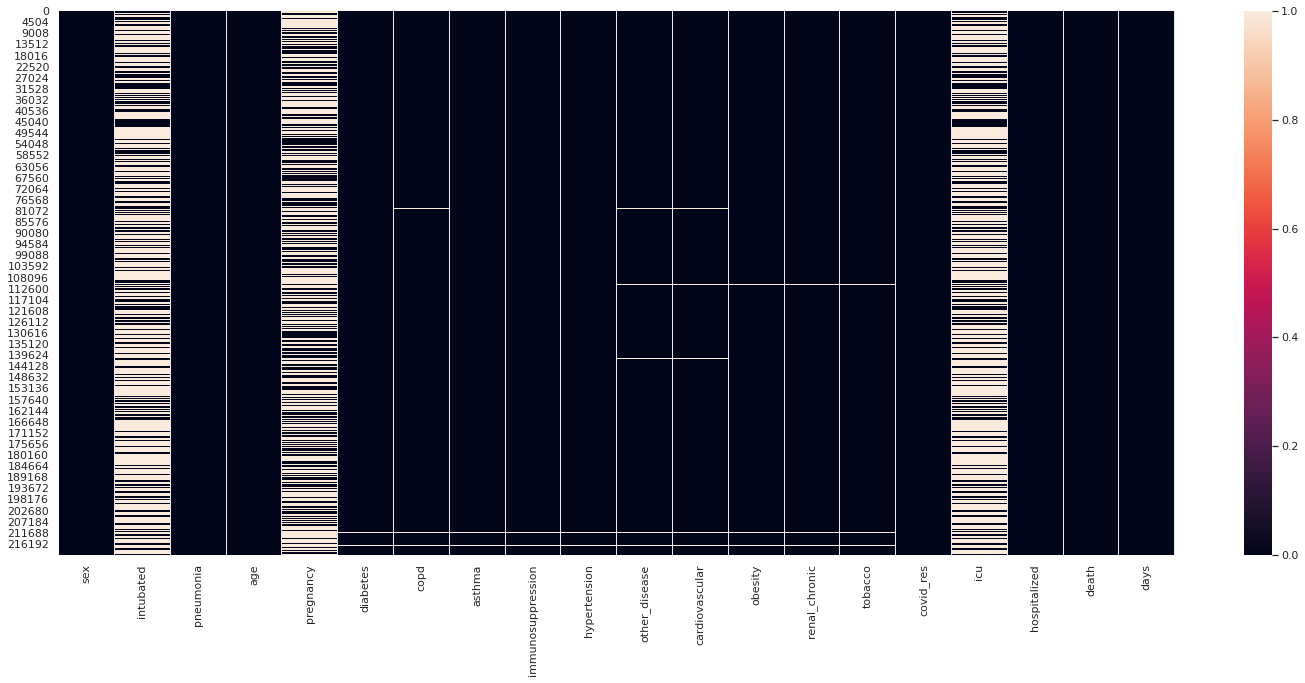

In [27]:
sb.set(rc={'figure.figsize':(25,10)})
sb.heatmap(positive_patients.isin([97, 98, 99]))

In [28]:
#missing values percentage
print('percentage of 97,98,99 in each columns')
print(((positive_patients.isin([97, 98, 99]).sum()/positive_patients.shape[0] * 100).round(3)).sort_values(ascending = False) )

percentage of 97,98,99 in each columns
icu                  69.088
intubated            69.087
pregnancy            55.055
other_disease         0.520
immunosuppression     0.395
tobacco               0.388
diabetes              0.386
cardiovascular        0.373
obesity               0.370
hypertension          0.363
renal_chronic         0.361
asthma                0.350
copd                  0.347
age                   0.037
pneumonia             0.001
days                  0.000
death                 0.000
covid_res             0.000
hospitalized          0.000
sex                   0.000
dtype: float64


In [29]:
pd.crosstab(positive_patients['intubated'], positive_patients['icu'])

icu,1,2,97,99
intubated,,,,
1,3179,3370,0,0
2,2643,59018,0,1
97,0,0,152361,0
99,0,0,0,85


In [30]:
pd.crosstab(positive_patients['hospitalized'],[positive_patients['intubated'], positive_patients['icu']])

intubated       1           2                 97  99
icu             1     2     1      2  99      97  99
hospitalized                                        
0                0     0     0      0  0  152361   0
1             3179  3370  2643  59018  1       0  85

In [31]:
pd.crosstab(positive_patients['pregnancy'], positive_patients['sex'])

sex,0,1
pregnancy,,
1,1425,0
2,97749,0
97,0,120799
98,684,0


In [32]:
#convert 97 to 2 for icu, intubated and pregnancy
for column in ['icu','intubated','pregnancy']:
  positive_patients[column] = positive_patients[column].replace(97,2)

In [33]:
#to check values of each columns
for column in positive_patients:
    print('{} : {}'.format(str(column),positive_patients[column].unique()))

sex : [1 0]
intubated : [ 2  1 99]
pneumonia : [ 2  1 99]
age : [ 27  24  54  30  60  47  63  56  41  39  46  45  28  34  38  49  25  40
  61  31  33  52  83  43  77  37  32  53  42  57  48  59  44  65  73  71
  51  50  35  67  55  78  29  79  36  66  74  58  84  26  80   3  75  68
  87  69  89  76  62  18  23  70  17  72   0  81  64  88  20  15  22  14
  16  86  92  90  82   5   7  11  21  85  95  19   1   4  97  10  93   9
   8  12  13   6  91   2  98  96  94 100 119 101  99 103 114 106 120 105
 102 116]
pregnancy : [ 2  1 98]
diabetes : [ 2  1 98]
copd : [ 2  1 98]
asthma : [ 2  1 98]
immunosuppression : [ 2  1 98]
hypertension : [ 2  1 98]
other_disease : [ 2  1 98]
cardiovascular : [ 2  1 98]
obesity : [ 2  1 98]
renal_chronic : [ 2  1 98]
tobacco : [ 2  1 98]
covid_res : [1]
icu : [ 2  1 99]
hospitalized : [0 1]
death : [0 1]
days : [-1  9 13  6  1  0  7  4 15 16 20 10 31 11  2  5 17  8 26 18  3 33 22 23
 14 19 12 21 35 43 25 37 28 36 34 24 32 41 27 30 46 38 45 29 39 44 51 40
 42

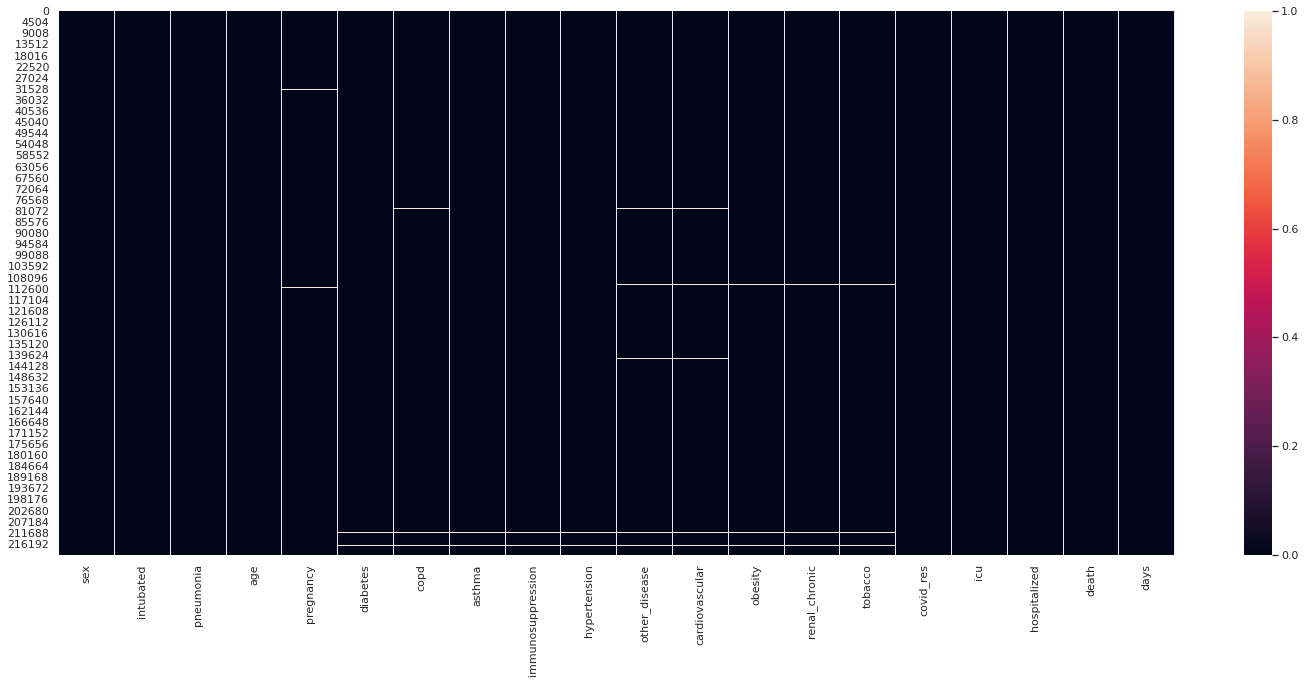

In [34]:
sb.set(rc={'figure.figsize':(25,10)})
sb.heatmap(positive_patients.isin([98, 99]))

In [35]:
#missing percentage
print('percentage of 98,99 in each columns')
print(((positive_patients.isin([98, 99]).sum()/positive_patients.shape[0] * 100).round(3)).sort_values(ascending = False))

percentage of 98,99 in each columns
other_disease        0.520
immunosuppression    0.395
tobacco              0.388
diabetes             0.386
cardiovascular       0.373
obesity              0.370
hypertension         0.363
renal_chronic        0.361
asthma               0.350
copd                 0.347
pregnancy            0.310
intubated            0.039
icu                  0.039
age                  0.022
pneumonia            0.001
days                 0.000
death                0.000
covid_res            0.000
hospitalized         0.000
sex                  0.000
dtype: float64


In [36]:
#dropping rows with values 98,99  and coverting 2 to 0 for all the columns
for column in ['intubated','pneumonia','pregnancy','diabetes','copd','asthma','immunosuppression','hypertension','other_disease','cardiovascular','obesity','renal_chronic','tobacco','covid_res','icu']:
    positive_patients[column] = positive_patients[column].replace(2,0)

for column in positive_patients:
  positive_patients.drop(positive_patients[positive_patients[column] == 98].index, inplace=True)
  positive_patients.drop(positive_patients[positive_patients[column] == 99].index, inplace=True)
positive_patients

,sex,intubated,pneumonia,age,pregnancy,diabetes,copd,asthma,immunosuppression,hypertension,other_disease,cardiovascular,obesity,renal_chronic,tobacco,covid_res,icu,hospitalized,death,days
0,1,0,0,27,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,-1
1,1,0,0,24,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,-1
2,0,0,0,54,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,-1
3,1,0,1,30,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,-1
4,0,0,0,60,0,1,0,0,0,1,0,1,0,0,0,1,0,1,1,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220652,0,0,1,88,0,1,0,0,0,1,0,0,0,0,0,1,0,1,1,0
220653,0,0,0,30,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,-1
220654,0,0,0,27,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,-1
220655,0,0,0,36,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,-1


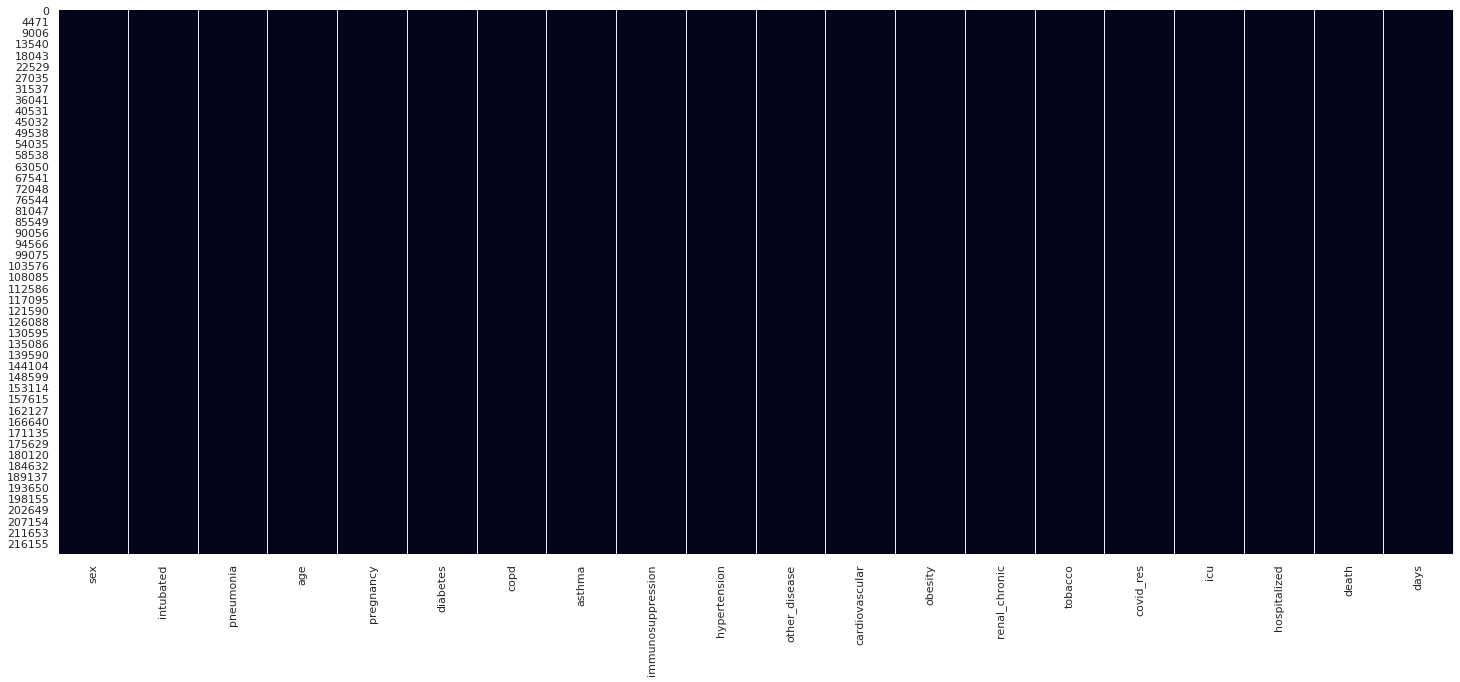

In [37]:
sb.set(rc={'figure.figsize':(25,10)})
sb.heatmap(positive_patients.isin([98, 99]),cbar = False)

In [38]:
#to check whether data has any other incorrect values
for column in positive_patients:
    print('{} : {}'.format(str(column),positive_patients[column].unique()))

sex : [1 0]
intubated : [0 1]
pneumonia : [0 1]
age : [ 27  24  54  30  60  47  63  56  41  39  46  45  28  34  38  49  25  40
  61  31  33  52  83  43  77  37  32  53  42  57  48  59  44  65  73  71
  51  50  35  67  55  78  29  79  36  66  74  58  84  26  80   3  75  68
  87  69  89  76  62  18  23  70  17  72   0  81  64  88  20  15  22  14
  16  86  92  90  82   5   7  11  21  85  95  19   1   4  97  10  93   9
   8  12  13   6  91   2  96  94 100 119 101 103 114 106 102 116 120]
pregnancy : [0 1]
diabetes : [0 1]
copd : [0 1]
asthma : [0 1]
immunosuppression : [0 1]
hypertension : [0 1]
other_disease : [0 1]
cardiovascular : [0 1]
obesity : [0 1]
renal_chronic : [0 1]
tobacco : [0 1]
covid_res : [1]
icu : [0 1]
hospitalized : [0 1]
death : [0 1]
days : [-1  9 13  6  1  0  7  4 15 16 20 10 31 11  2  5 17  8 26 18  3 33 22 23
 14 19 12 21 35 43 25 37 28 36 34 24 32 41 27 30 46 38 45 29 39 44 51 40
 42 47 56 61 53 49 48 55 54 50 59 66 68 52 63 76 79 57]


In [39]:
# droping covid_res field as all the patients are positive
positive_patients = positive_patients.drop(columns=['covid_res'])

In [40]:
positive_patients

,sex,intubated,pneumonia,age,pregnancy,diabetes,copd,asthma,immunosuppression,hypertension,other_disease,cardiovascular,obesity,renal_chronic,tobacco,icu,hospitalized,death,days
0,1,0,0,27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1
1,1,0,0,24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1
2,0,0,0,54,0,0,0,0,0,0,0,0,1,0,0,0,1,0,-1
3,1,0,1,30,0,0,0,0,0,0,0,0,0,0,0,0,1,0,-1
4,0,0,0,60,0,1,0,0,0,1,0,1,0,0,0,0,1,1,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220652,0,0,1,88,0,1,0,0,0,1,0,0,0,0,0,0,1,1,0
220653,0,0,0,30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1
220654,0,0,0,27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1
220655,0,0,0,36,0,0,0,1,0,0,0,0,0,0,0,0,0,0,-1


                        sex  intubated  ...     death      days
sex                1.000000   0.044819  ...  0.083183  0.064711
intubated          0.044819   1.000000  ...  0.291172  0.247064
pneumonia          0.090767   0.284070  ...  0.457988  0.340288
age                0.045724   0.122430  ...  0.351844  0.257238
pregnancy          0.089146   0.007174  ...  0.024596  0.017462
diabetes           0.006262   0.088921  ...  0.207547  0.138926
copd               0.003041   0.028539  ...  0.090608  0.060532
asthma             0.049304   0.010039  ...  0.015978  0.009719
immunosuppression  0.012455   0.016138  ...  0.048200  0.032434
hypertension       0.006584   0.073951  ...  0.206703  0.144329
other_disease      0.030069   0.007356  ...  0.050694  0.036330
cardiovascular     0.007197   0.029282  ...  0.073595  0.049145
obesity            0.024756   0.040088  ...  0.051842  0.030584
renal_chronic      0.011336   0.033543  ...  0.117130  0.074220
tobacco            0.100046   0.005788  

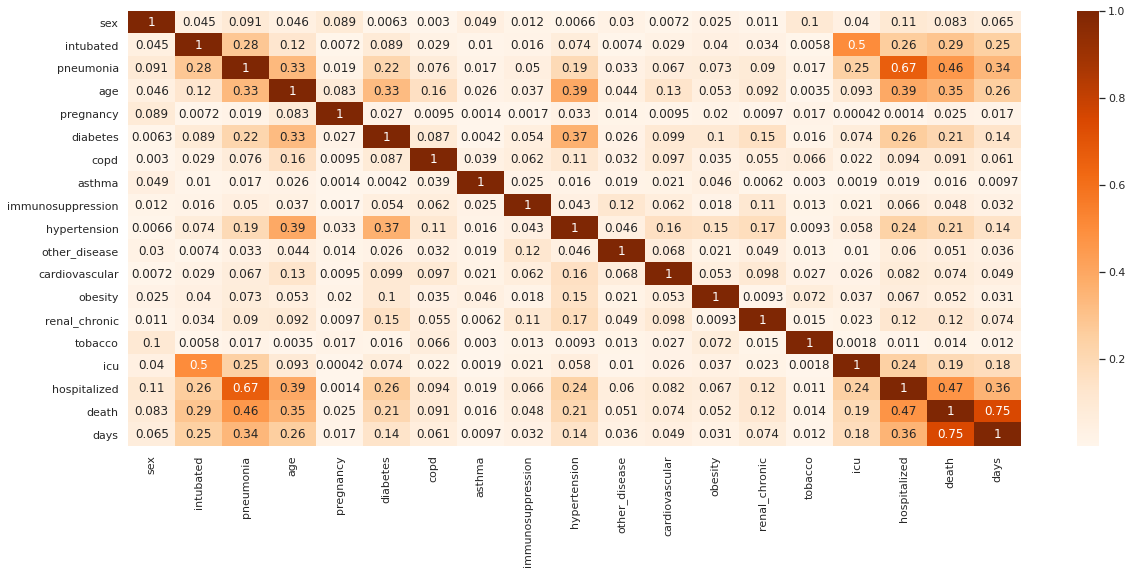

In [41]:
#finding corelation coefficient by pearson's correlation
corr_matrix = positive_patients.corr().abs()
print(corr_matrix)
plt.figure(figsize=(20, 8))
sb.heatmap(corr_matrix, annot=True, cmap='Oranges')

#selecting upper triangle
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

#getting columns if it has greater than 0.8 corelation coefficiant
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]
print(to_drop)

In [42]:
positive_patients

,sex,intubated,pneumonia,age,pregnancy,diabetes,copd,asthma,immunosuppression,hypertension,other_disease,cardiovascular,obesity,renal_chronic,tobacco,icu,hospitalized,death,days
0,1,0,0,27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1
1,1,0,0,24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1
2,0,0,0,54,0,0,0,0,0,0,0,0,1,0,0,0,1,0,-1
3,1,0,1,30,0,0,0,0,0,0,0,0,0,0,0,0,1,0,-1
4,0,0,0,60,0,1,0,0,0,1,0,1,0,0,0,0,1,1,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220652,0,0,1,88,0,1,0,0,0,1,0,0,0,0,0,0,1,1,0
220653,0,0,0,30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1
220654,0,0,0,27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1
220655,0,0,0,36,0,0,0,1,0,0,0,0,0,0,0,0,0,0,-1


# Export Cleaned Dataset

In [43]:
positive_patients.to_csv('cleaned_covid.csv', index = False)

deaths : 26625 - 12.21% 
alive : 191518 - 87.79% 


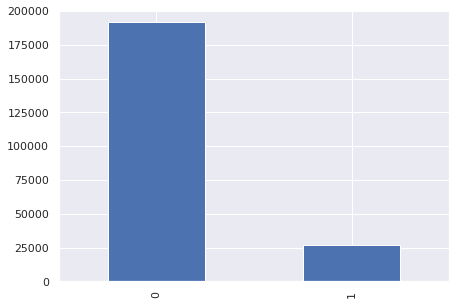

In [44]:
sb.set(rc={'figure.figsize':(7,5)})
positive_patients['death'].value_counts().plot(kind='bar')
deaths = len(positive_patients[positive_patients['death'] == 1])
alive = len(positive_patients[positive_patients['death'] == 0])

print('deaths : {} - {:.2f}% '.format(deaths,deaths*100/len(positive_patients)))
print('alive : {} - {:.2f}% '.format(alive,alive*100/len(positive_patients)))

# Logistic Regression

In [45]:
def CalculateMetricsLogisticRegression(dataset):
    target='death'
    X = dataset.drop([target,'days'],axis=1)
    Y = dataset[target]
    X,Y = shuffle(X,Y)
    X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.25,random_state=12)

    logistic_regression = LogisticRegression(max_iter=200)
    logistic_regression.fit(X_train,Y_train)
    Y_pred_logistic = logistic_regression.predict(X_test)
    Y_pred_logistic.reshape(len(Y_pred_logistic))


    Y_pred_logistic_prob=logistic_regression.decision_function(X_test)
    Y_pred_logistic_prob.reshape(len(Y_pred_logistic_prob))



    confusion_matrix = pd.crosstab(Y_test, Y_pred_logistic, rownames=['Actual Values'], colnames=['Predicted Values'])
    sb.heatmap(confusion_matrix, annot=True, fmt='d', cmap='YlGnBu')
    plt.show()

    print('Precision: ',metrics.precision_score(Y_test, Y_pred_logistic))
    print('Recall: ',metrics.recall_score(Y_test, Y_pred_logistic))
    print('F1-score: ',metrics.f1_score(Y_test, Y_pred_logistic))

    fpr_logistic, tpr_logistic, thresholds_logistic = roc_curve(Y_test, Y_pred_logistic_prob)
    auc_logistic = auc(fpr_logistic, tpr_logistic)
    
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_logistic, tpr_logistic, label='Logistic Regression (area = {:.3f})'.format(auc_logistic))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()
    # if metrics.f1_score(Y_test, Y_pred) > 0.8:
    #   with open('covid_classsification.pkl','wb') as file:
    #     pickle.dump(logistic_regression, file)
    #     print('pickle file created successfully')

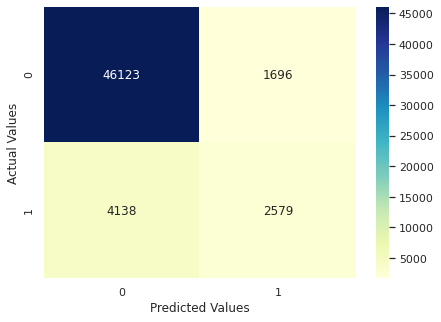

Precision:  0.6032748538011696
Recall:  0.3839511686764925
F1-score:  0.46925036390101893


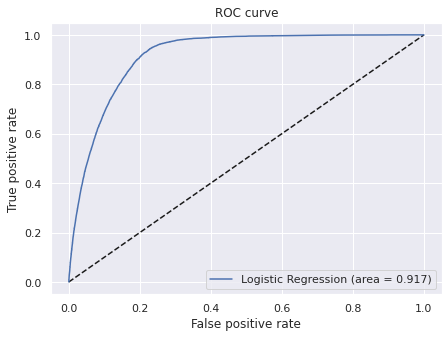

In [46]:
CalculateMetricsLogisticRegression(positive_patients)

# Over SAMPLING

In [47]:
positive_patients['death'].value_counts()

0    191518
1     26625
Name: death, dtype: int64

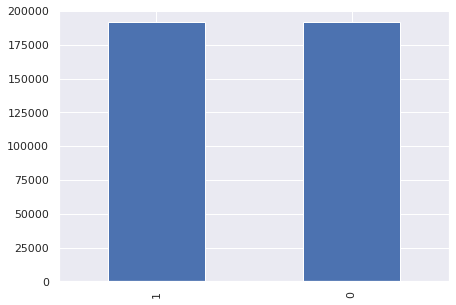

In [48]:
patients_majority = positive_patients[positive_patients.death==0]
patients_minority = positive_patients[positive_patients.death==1]
patients_majority_length = len(patients_majority)

patients_sample = resample(patients_minority, 
                                 replace=True,     # sample without replacement
                                 n_samples=patients_majority_length,    # to match majority class
                                 random_state=123)
                                 

positive_patients_oversampled = pd.concat([patients_majority, patients_sample])
positive_patients_oversampled.death.value_counts().plot(kind='bar')

In [49]:
positive_patients_oversampled

,sex,intubated,pneumonia,age,pregnancy,diabetes,copd,asthma,immunosuppression,hypertension,other_disease,cardiovascular,obesity,renal_chronic,tobacco,icu,hospitalized,death,days
0,1,0,0,27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1
1,1,0,0,24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1
2,0,0,0,54,0,0,0,0,0,0,0,0,1,0,0,0,1,0,-1
3,1,0,1,30,0,0,0,0,0,0,0,0,0,0,0,0,1,0,-1
6,1,0,0,63,0,0,0,0,0,1,0,0,0,0,0,0,1,0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108306,1,1,1,72,0,1,0,0,0,0,0,0,0,0,0,0,1,1,15
67705,0,0,1,50,0,1,0,0,0,0,0,0,0,0,0,0,1,1,10
214741,1,0,1,73,0,1,0,0,0,1,0,0,0,1,0,0,1,1,7
111454,0,0,0,74,0,1,0,0,0,0,0,0,1,0,0,0,1,1,4


# Logistic Regression after Over Sampling

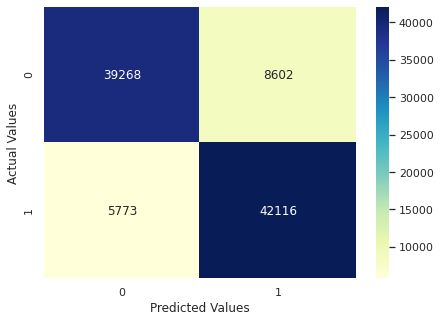

Precision:  0.8303955203280886
Recall:  0.8794503957067386
F1-score:  0.8542192744936972


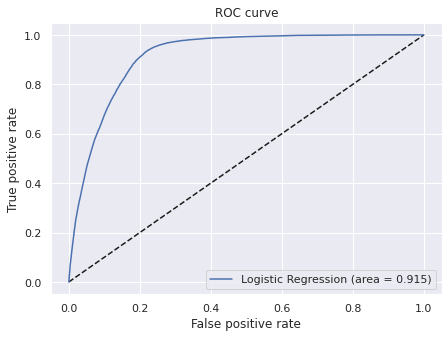

In [50]:
CalculateMetricsLogisticRegression(positive_patients_oversampled)

# Under SAMPLING

In [51]:
positive_patients['death'].value_counts()

0    191518
1     26625
Name: death, dtype: int64

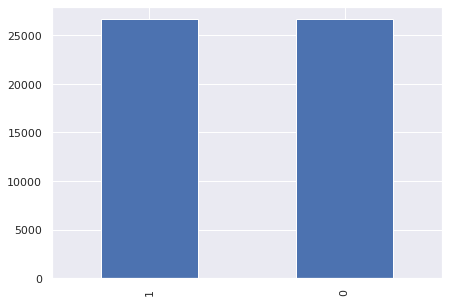

In [52]:
patients_majority = positive_patients[positive_patients.death==0]
patients_minority = positive_patients[positive_patients.death==1]
patients_minority_length = len(patients_minority)

patients_sample = resample(patients_majority, 
                                 replace=False,     # sample without replacement
                                 n_samples=patients_minority_length,    # to match majority class
                                 random_state=123)
                                 

positive_patients_undersampled = pd.concat([patients_minority, patients_sample])
positive_patients_undersampled.death.value_counts().plot(kind='bar')

In [53]:
positive_patients_undersampled

,sex,intubated,pneumonia,age,pregnancy,diabetes,copd,asthma,immunosuppression,hypertension,other_disease,cardiovascular,obesity,renal_chronic,tobacco,icu,hospitalized,death,days
4,0,0,0,60,0,1,0,0,0,1,0,1,0,0,0,0,1,1,9
5,1,0,1,47,0,1,0,0,0,0,0,0,0,0,0,1,1,1,13
24,0,0,0,61,0,0,0,0,0,1,0,0,0,0,0,0,0,1,6
36,1,0,1,77,0,0,0,0,0,1,0,0,0,0,0,0,1,1,1
41,0,0,1,53,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40744,1,0,0,22,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1
2297,1,0,0,24,0,0,0,0,0,0,0,0,0,0,0,0,1,0,-1
61485,1,0,0,44,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1
91758,0,0,0,78,0,1,0,0,0,1,0,0,0,1,0,0,0,0,-1


# Logistic Regression after Under Sampling

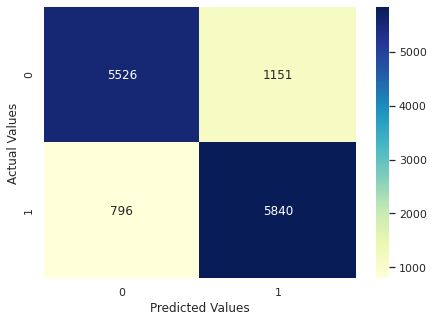

Precision:  0.8353597482477471
Recall:  0.8800482218203737
F1-score:  0.8571218903647171


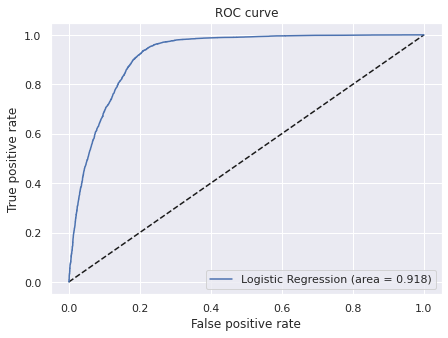

In [54]:
CalculateMetricsLogisticRegression(positive_patients_undersampled)

# Under and Over SAMPLING combination

In [55]:
positive_patients['death'].value_counts()

0    191518
1     26625
Name: death, dtype: int64

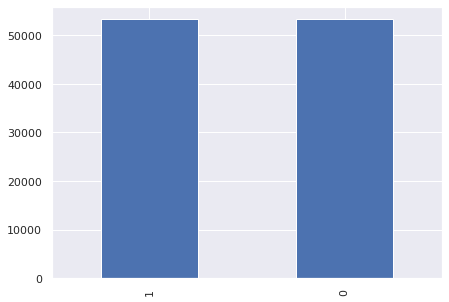

In [56]:
patients_majority = positive_patients[positive_patients.death==0]
patients_minority = positive_patients[positive_patients.death==1]
patients_minority_length = len(patients_minority)
patients_majority_length = len(patients_majority)


patients_minority = resample(patients_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=patients_minority_length * 2,    # to match majority class
                                 random_state=123)
                                 
patients_majority = resample(patients_majority, 
                                 replace=False,     # sample without replacement
                                 n_samples=patients_minority_length * 2,    # to match majority class
                                 random_state=123)
                                 
positive_patients_mixedsampled = pd.concat([patients_minority, patients_majority])
positive_patients_mixedsampled.death.value_counts().plot(kind='bar')

In [57]:
positive_patients_mixedsampled

,sex,intubated,pneumonia,age,pregnancy,diabetes,copd,asthma,immunosuppression,hypertension,other_disease,cardiovascular,obesity,renal_chronic,tobacco,icu,hospitalized,death,days
164897,1,1,0,41,0,0,0,0,0,0,0,0,0,0,0,0,1,1,44
129352,0,0,1,52,0,0,0,0,0,0,0,0,0,0,0,0,1,1,29
146548,1,1,0,70,0,0,0,0,0,1,0,0,0,0,0,0,1,1,15
178649,1,0,1,53,0,1,0,0,0,0,0,0,0,0,0,0,1,1,2
126188,0,0,1,71,0,0,0,0,0,0,0,0,0,0,0,0,1,1,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146177,0,0,0,23,0,0,0,0,0,0,0,0,1,0,1,0,0,0,-1
115084,0,0,0,29,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1
202222,0,0,0,29,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1
156847,1,0,0,32,0,0,0,0,0,0,0,0,1,0,0,0,0,0,-1


# Logistic Regression after Mixed Sampling

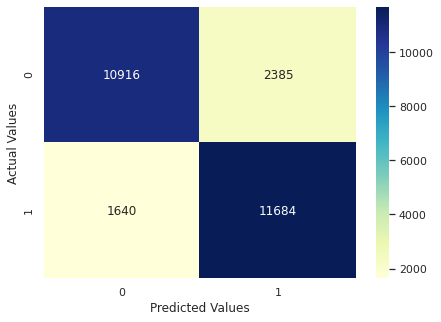

Precision:  0.8304783566706945
Recall:  0.8769138396877815
F1-score:  0.8530646515533166


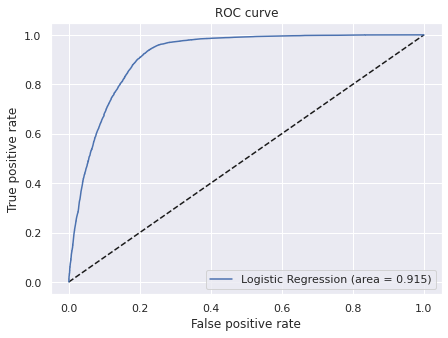

In [58]:
CalculateMetricsLogisticRegression(positive_patients_mixedsampled)

# Export Oversampled dataset for classification

In [59]:
positive_patients_oversampled.to_csv('covid_classification_oversampled.csv',index=False)

# Splitting Data

In [60]:
target='death'
X = positive_patients_oversampled.drop([target,'days'],axis=1)
Y = positive_patients_oversampled[target]
X,Y = shuffle(X,Y)
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.25,random_state=12)

In [61]:
p_scores = {}
r_scores = {}
f1_scores = {}

# Classification

Logistic Regression

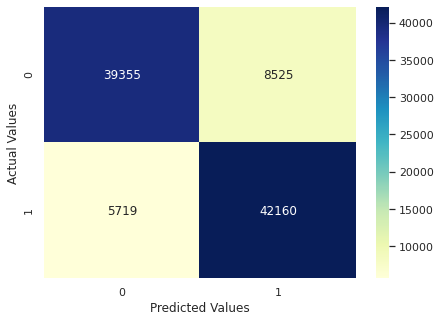

Precision:  0.8318042813455657
Recall:  0.8805530608408697
F1-score:  0.8554847611704071


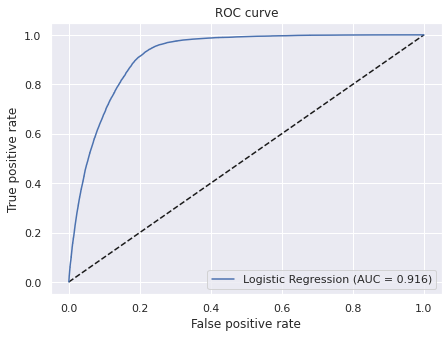

In [62]:
logistic_regression = LogisticRegression(max_iter=200)
logistic_regression.fit(X_train,Y_train)
Y_pred_logistic_prob=logistic_regression.decision_function(X_test)
Y_pred_logistic_prob.reshape(len(Y_pred_logistic_prob))

Y_pred_logistic = logistic_regression.predict(X_test)

confusion_matrix = pd.crosstab(Y_test, Y_pred_logistic, rownames=['Actual Values'], colnames=['Predicted Values'])
sb.heatmap(confusion_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

print('Precision: ',metrics.precision_score(Y_test, Y_pred_logistic))
print('Recall: ',metrics.recall_score(Y_test, Y_pred_logistic))
print('F1-score: ',metrics.f1_score(Y_test, Y_pred_logistic))

fpr_logistic, tpr_logistic, thresholds_logistic = roc_curve(Y_test, Y_pred_logistic_prob)
auc_logistic = auc(fpr_logistic, tpr_logistic)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_logistic, tpr_logistic, label='Logistic Regression (AUC = {:.3f})'.format(auc_logistic))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

p_scores['logistic'] = metrics.precision_score(Y_test, Y_pred_logistic)
r_scores['logistic'] = metrics.recall_score(Y_test, Y_pred_logistic)
f1_scores['logistic'] = metrics.f1_score(Y_test, Y_pred_logistic)

Decision Tree

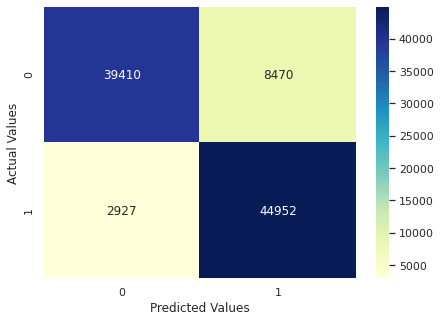

Precision:  0.84145108756692
Recall:  0.9388667265398192
F1-score:  0.8874937068735749


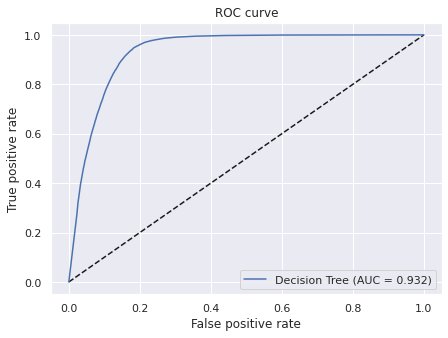

In [63]:
decisionTree_classifier = DecisionTreeClassifier()
decisionTree_classifier.fit(X_train,Y_train)
Y_pred_decision = decisionTree_classifier.predict(X_test)
Y_pred_decision_prob = decisionTree_classifier.predict_proba(X_test)

confusion_matrix = pd.crosstab(Y_test, Y_pred_decision, rownames=['Actual Values'], colnames=['Predicted Values'])
sb.heatmap(confusion_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

print('Precision: ',metrics.precision_score(Y_test, Y_pred_decision))
print('Recall: ',metrics.recall_score(Y_test, Y_pred_decision))
print('F1-score: ',metrics.f1_score(Y_test, Y_pred_decision))

fpr_decision, tpr_decision, thresholds_decision = roc_curve(Y_test, Y_pred_decision_prob[:,1])
auc_decision = auc(fpr_decision, tpr_decision)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_decision, tpr_decision, label='Decision Tree (AUC = {:.3f})'.format(auc_decision))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()


p_scores['decision'] = metrics.precision_score(Y_test, Y_pred_decision)
r_scores['decision'] = metrics.recall_score(Y_test, Y_pred_decision)
f1_scores['decision'] = metrics.f1_score(Y_test, Y_pred_decision)

Random Forest Classifier

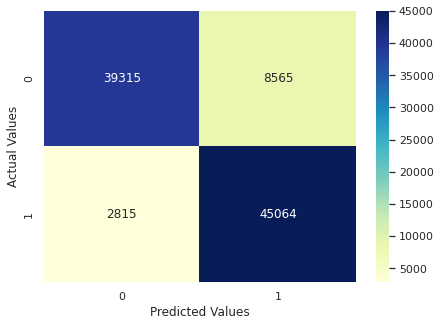

Precision:  0.8402916332581253
Recall:  0.9412059566824704
F1-score:  0.8878906096071245


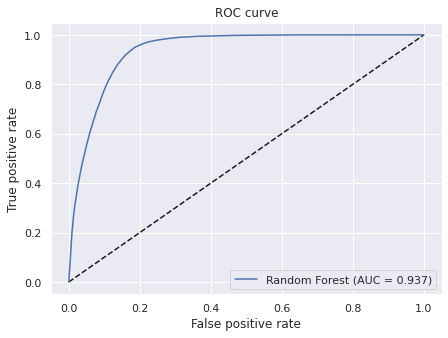

In [64]:
random_forest_classifier = RandomForestClassifier()
random_forest_classifier.fit(X_train,Y_train)
Y_pred_forest = random_forest_classifier.predict(X_test)

Y_pred_forest_prob = random_forest_classifier.predict_proba(X_test)

confusion_matrix = pd.crosstab(Y_test, Y_pred_forest, rownames=['Actual Values'], colnames=['Predicted Values'])
sb.heatmap(confusion_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

print('Precision: ',metrics.precision_score(Y_test, Y_pred_forest))
print('Recall: ',metrics.recall_score(Y_test, Y_pred_forest))
print('F1-score: ',metrics.f1_score(Y_test, Y_pred_forest))


fpr_forest, tpr_forest, thresholds_forest = roc_curve(Y_test, Y_pred_forest_prob[:,1])
auc_forest = auc(fpr_forest, tpr_forest)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_forest, tpr_forest, label='Random Forest (AUC = {:.3f})'.format(auc_forest))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

p_scores['random'] = metrics.precision_score(Y_test, Y_pred_forest)
r_scores['random'] = metrics.recall_score(Y_test, Y_pred_forest)
f1_scores['random'] = metrics.f1_score(Y_test, Y_pred_forest)

 Neural Network

In [65]:
#defining Model
classification_model = Sequential()
classification_model.add(Dense(25, input_dim=17, activation='relu'))
classification_model.add(Dense(10, activation='relu'))
classification_model.add(Dense(1, activation='sigmoid'))

In [66]:
classification_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy','binary_crossentropy'])

In [67]:
history = classification_model.fit(X_train, Y_train, epochs=100, batch_size=1000)

Epoch 1/100
288/288 [==============================] - 4s 3ms/step - loss: 1.1777 - accuracy: 0.6501 - binary_crossentropy: 1.1777
Epoch 2/100
288/288 [==============================] - 1s 2ms/step - loss: 0.3745 - accuracy: 0.8496 - binary_crossentropy: 0.3745
Epoch 3/100
288/288 [==============================] - 1s 2ms/step - loss: 0.3493 - accuracy: 0.8587 - binary_crossentropy: 0.3493
Epoch 4/100
288/288 [==============================] - 1s 2ms/step - loss: 0.3456 - accuracy: 0.8582 - binary_crossentropy: 0.3456
Epoch 5/100
288/288 [==============================] - 1s 2ms/step - loss: 0.3420 - accuracy: 0.8593 - binary_crossentropy: 0.3420
Epoch 6/100
288/288 [==============================] - 1s 2ms/step - loss: 0.3423 - accuracy: 0.8594 - binary_crossentropy: 0.3423
Epoch 7/100
288/288 [==============================] - 1s 3ms/step - loss: 0.3399 - accuracy: 0.8611 - binary_crossentropy: 0.3399
Epoch 8/100
288/288 [==============================] - 1s 2ms/step - loss: 0.3419 -

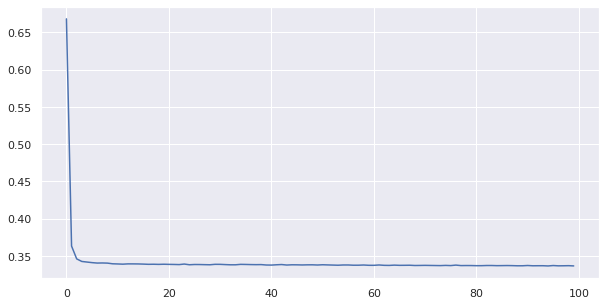

In [68]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['binary_crossentropy'])
plt.show()

In [69]:
#predicting for testing samples
Y_pred_keras = classification_model.predict(X_test)
Y_pred_keras_prob = np.array(Y_pred_keras)

In [70]:
#converting probabilty to 0 and 1 class at 0.5 threshold value
for i in range(len(Y_pred_keras)):
  if Y_pred_keras[i][0]>0.5:
    Y_pred_keras[i][0] = 1
  else:
    Y_pred_keras[i][0] = 0

In [71]:
#reshaping predicted values
Y_pred_keras = Y_pred_keras.reshape(len(Y_pred_keras))

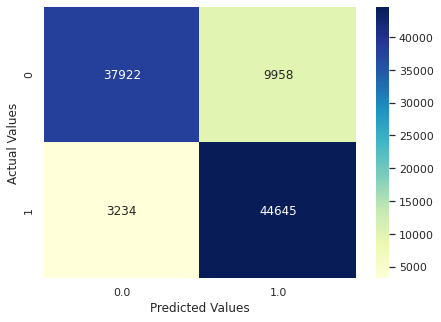

Precision:  0.8176290679999267
Recall:  0.9324547296309447
F1-score:  0.8712749556019593


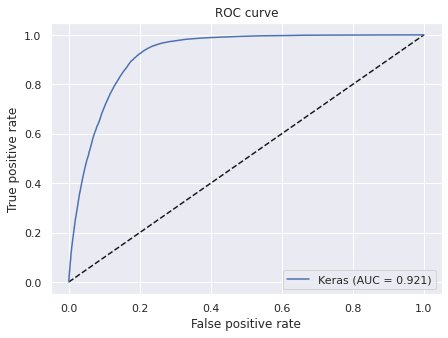

In [72]:
#creating confusion matrix for test case
confusion_matrix = pd.crosstab(Y_test, Y_pred_keras, rownames=['Actual Values'], colnames=['Predicted Values'])
sb.heatmap(confusion_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

print('Precision: ',metrics.precision_score(Y_test, Y_pred_keras))
print('Recall: ',metrics.recall_score(Y_test, Y_pred_keras))
print('F1-score: ',metrics.f1_score(Y_test, Y_pred_keras))

fpr_keras, tpr_keras, thresholds_keras = roc_curve(Y_test, Y_pred_keras_prob)
auc_keras = auc(fpr_keras, tpr_keras)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (AUC = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

p_scores['neural'] = metrics.precision_score(Y_test, Y_pred_keras)
r_scores['neural'] = metrics.recall_score(Y_test, Y_pred_keras)
f1_scores['neural'] = metrics.f1_score(Y_test, Y_pred_keras)

Comparing ROC Curve of all the classification Models

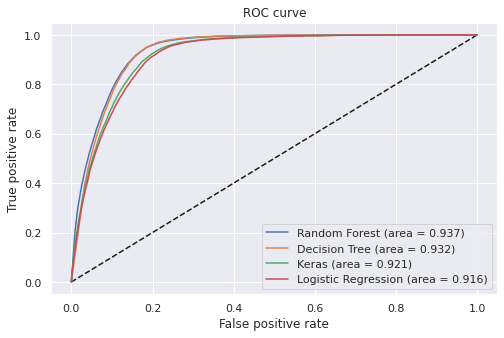

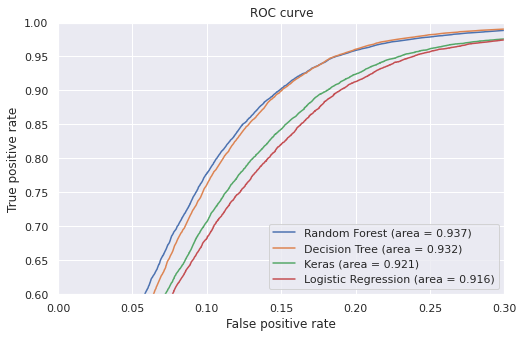

In [73]:
plt.figure(1,figsize=(8,5))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_forest, tpr_forest, label='Random Forest (area = {:.3f})'.format(auc_forest))
plt.plot(fpr_decision, tpr_decision, label='Decision Tree (area = {:.3f})'.format(auc_decision))
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.plot(fpr_logistic, tpr_logistic, label='Logistic Regression (area = {:.3f})'.format(auc_logistic))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

plt.figure(2,figsize=(8,5))
plt.xlim(0,0.3)
plt.ylim(0.6,1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_forest, tpr_forest, label='Random Forest (area = {:.3f})'.format(auc_forest))
plt.plot(fpr_decision, tpr_decision, label='Decision Tree (area = {:.3f})'.format(auc_decision))
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.plot(fpr_logistic, tpr_logistic, label='Logistic Regression (area = {:.3f})'.format(auc_logistic))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

Comparing Metrics of all classification models

In [74]:
print('Precision : ',p_scores)
print('Recall : ',r_scores)
print('f1 scores : ',f1_scores)

Precision :  {'logistic': 0.8318042813455657, 'decision': 0.84145108756692, 'random': 0.8402916332581253, 'neural': 0.8176290679999267}
Recall :  {'logistic': 0.8805530608408697, 'decision': 0.9388667265398192, 'random': 0.9412059566824704, 'neural': 0.9324547296309447}
f1 scores :  {'logistic': 0.8554847611704071, 'decision': 0.8874937068735749, 'random': 0.8878906096071245, 'neural': 0.8712749556019593}


In [75]:
model_names = ['Logistic Regression','Decision Tree','Random Forest','Neural Network']
p_scores_list = [round(p_scores['logistic'],2),round(p_scores['decision'],2),round(p_scores['random'],2),round(p_scores['neural'],2)]
r_scores_list = [round(r_scores['logistic'],2),round(r_scores['decision'],2),round(r_scores['random'],2),round(r_scores['neural'],2)]
f1_scores_list = [round(f1_scores['logistic'],2),round(f1_scores['decision'],2),round(f1_scores['random'],2),round(f1_scores['neural'],2)]

In [76]:
scores = pd.DataFrame(np.array([model_names, p_scores_list,r_scores_list, f1_scores_list])).transpose().rename(columns={0:'Models',1:'Precision',2:'recall',3:'f1 score'})

In [77]:
scores

,Models,Precision,recall,f1 score
0,Logistic Regression,0.83,0.88,0.86
1,Decision Tree,0.84,0.94,0.89
2,Random Forest,0.84,0.94,0.89
3,Neural Network,0.82,0.93,0.87


# Regression

In [78]:
positive_patients

,sex,intubated,pneumonia,age,pregnancy,diabetes,copd,asthma,immunosuppression,hypertension,other_disease,cardiovascular,obesity,renal_chronic,tobacco,icu,hospitalized,death,days
0,1,0,0,27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1
1,1,0,0,24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1
2,0,0,0,54,0,0,0,0,0,0,0,0,1,0,0,0,1,0,-1
3,1,0,1,30,0,0,0,0,0,0,0,0,0,0,0,0,1,0,-1
4,0,0,0,60,0,1,0,0,0,1,0,1,0,0,0,0,1,1,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220652,0,0,1,88,0,1,0,0,0,1,0,0,0,0,0,0,1,1,0
220653,0,0,0,30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1
220654,0,0,0,27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1
220655,0,0,0,36,0,0,0,1,0,0,0,0,0,0,0,0,0,0,-1


In [79]:
#extracting regression data
regression_dataset = positive_patients[positive_patients['days'] > 0]
regression_dataset = regression_dataset.reset_index()
regression_dataset = regression_dataset.drop('index',axis=1)
regression_dataset

,sex,intubated,pneumonia,age,pregnancy,diabetes,copd,asthma,immunosuppression,hypertension,other_disease,cardiovascular,obesity,renal_chronic,tobacco,icu,hospitalized,death,days
0,0,0,0,60,0,1,0,0,0,1,0,1,0,0,0,0,1,1,9
1,1,0,1,47,0,1,0,0,0,0,0,0,0,0,0,1,1,1,13
2,0,0,0,61,0,0,0,0,0,1,0,0,0,0,0,0,0,1,6
3,1,0,1,77,0,0,0,0,0,1,0,0,0,0,0,0,1,1,1
4,1,0,1,77,0,0,1,0,0,0,0,0,0,0,1,0,1,1,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24595,1,0,1,36,0,0,0,0,0,0,0,0,0,0,0,0,1,1,18
24596,0,0,1,64,0,1,0,0,0,1,0,0,1,0,0,0,1,1,2
24597,0,0,0,59,0,1,0,0,0,1,0,0,1,0,0,0,1,1,7
24598,1,0,1,66,0,1,0,0,0,0,0,0,0,0,0,0,1,1,1


In [80]:
regression_dataset.describe()

,sex,intubated,pneumonia,age,pregnancy,diabetes,copd,asthma,immunosuppression,hypertension,other_disease,cardiovascular,obesity,renal_chronic,tobacco,icu,hospitalized,death,days
count,24600.000000,24600.000000,24600.000000,24600.000000,24600.000000,24600.000000,24600.000000,24600.000000,24600.000000,24600.000000,24600.000000,24600.000000,24600.000000,24600.000000,24600.000000,24600.000000,24600.000000,24600.0,24600.000000
mean,0.660041,0.160447,0.769024,61.052480,0.001220,0.367317,0.048943,0.020407,0.028618,0.419919,0.050244,0.052114,0.247683,0.067439,0.089309,0.110244,0.900813,1.0,7.892764
std,0.473705,0.367028,0.421465,14.041834,0.034901,0.482084,0.215753,0.141389,0.166733,0.493555,0.218452,0.222261,0.431675,0.250786,0.285195,0.313200,0.298919,0.0,6.857937
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.000000
25%,0.000000,0.000000,1.000000,52.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.0,3.000000
50%,1.000000,0.000000,1.000000,61.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.0,6.000000
75%,1.000000,0.000000,1.000000,71.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.0,11.000000
max,1.000000,1.000000,1.000000,103.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,79.000000


# Exporting Regression Dataset

In [81]:
regression_dataset.to_csv('covid_regression.csv', index=False)

# Splitting the data

In [82]:
target='days'
X = regression_dataset.drop([target,'death'],axis=1)
Y = regression_dataset[target]
X,Y = shuffle(X,Y)
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.25,random_state=12)

# Min-Max Normalization

In [83]:
scaler = MinMaxScaler()
scaler.fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Relation between age and death days

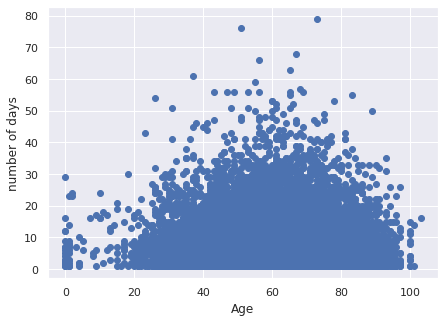

In [84]:
fig,ax =plt.subplots()
ax.scatter(X['age'],Y)
ax.set_xlabel('Age')
ax.set_ylabel('number of days')
mae_scores={}

In [85]:
mae_scores = {}
mse_scores = {}
r2_scores = {}

# Linear Regression

Mean Absolute Error : 5.062200311250608
Mean SquaredError : 49.25310730075614
r2 score : 0.01126645425915862


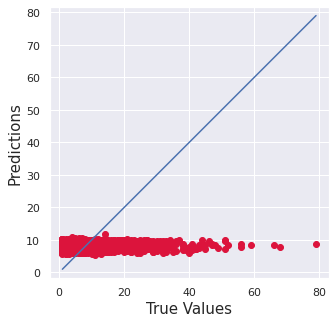

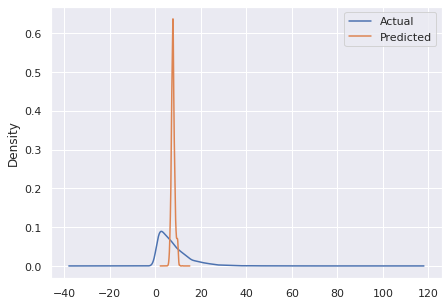

In [86]:
linear_regression = LinearRegression()
linear_regression.fit(X_train,Y_train)
Y_pred = np.array(linear_regression.predict(X_test))

print('Mean Absolute Error :',mean_absolute_error(Y_test,Y_pred))
print('Mean SquaredError :',mean_squared_error(Y_test,Y_pred))
print('r2 score :',r2_score(Y_test,Y_pred))


plt.figure(figsize=(5,5))
plt.scatter(Y_test, Y_pred, c='crimson')

p1 = max(max(Y_pred), max(Y_test))
p2 = min(min(Y_pred), min(Y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

pd.DataFrame({'Actual': np.array(Y_test),'Predicted':np.array(Y_pred)}).plot(kind='kde')

mae_scores['linear'] = mean_absolute_error(Y_test,Y_pred)
mse_scores['linear'] = mean_squared_error(Y_test,Y_pred)
r2_scores['linear'] = r2_score(Y_test,Y_pred)

SVM

Mean Absolute Error : 4.903883973052011
Mean SquaredError : 53.45969723545348
r2 score : -0.07317890989245868


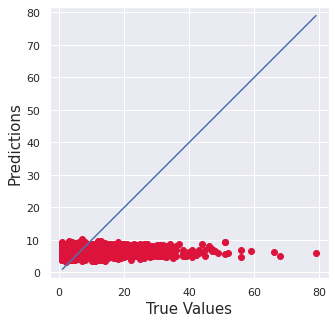

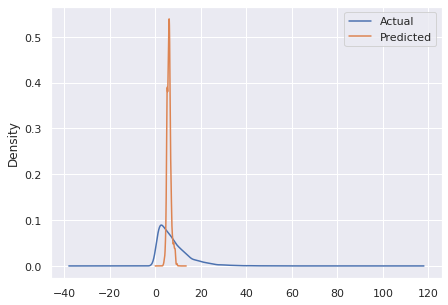

In [87]:
from sklearn import svm
regr = svm.SVR()
regr.fit(X_train, Y_train)
Y_pred = regr.predict(X_test)

print('Mean Absolute Error :',mean_absolute_error(Y_test,Y_pred))
print('Mean SquaredError :',mean_squared_error(Y_test,Y_pred))
print('r2 score :',r2_score(Y_test,Y_pred))

plt.figure(figsize=(5,5))
plt.scatter(Y_test, Y_pred, c='crimson')

p1 = max(max(Y_pred), max(Y_test))
p2 = min(min(Y_pred), min(Y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

pd.DataFrame({'Actual': np.array(Y_test),'Predicted':np.array(Y_pred)}).plot(kind='kde')

mae_scores['svm'] = mean_absolute_error(Y_test,Y_pred)
mse_scores['svm'] = mean_squared_error(Y_test,Y_pred)
r2_scores['svm'] = r2_score(Y_test,Y_pred)

Decision Tree Regressor

Mean Absolute Error : 6.072584505905288
Mean SquaredError : 73.61936196277009
r2 score : -0.47787493577101925


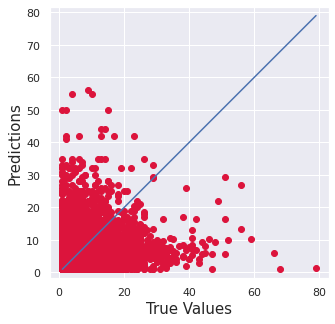

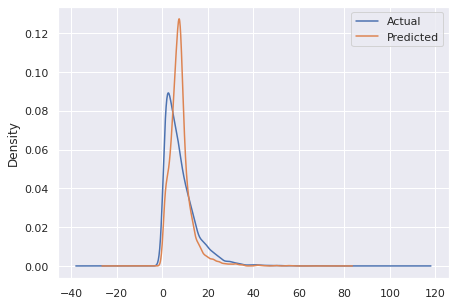

In [88]:
from sklearn.tree import DecisionTreeRegressor
clf = DecisionTreeRegressor()
clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)

print('Mean Absolute Error :',mean_absolute_error(Y_test,Y_pred))
print('Mean SquaredError :',mean_squared_error(Y_test,Y_pred))
print('r2 score :',r2_score(Y_test,Y_pred))

plt.figure(figsize=(5,5))
plt.scatter(Y_test, Y_pred, c='crimson')

p1 = max(max(Y_pred), max(Y_test))
p2 = min(min(Y_pred), min(Y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

pd.DataFrame({'Actual': np.array(Y_test),'Predicted':np.array(Y_pred)}).plot(kind='kde')

mae_scores['decision'] = mean_absolute_error(Y_test,Y_pred)
mse_scores['decision'] = mean_squared_error(Y_test,Y_pred)
r2_scores['decision'] = r2_score(Y_test,Y_pred)

Gradient Boosting

Mean Absolute Error : 5.073980502929229
Mean Squared Error : 49.28925551021683
r2 score : 0.010540795528755864


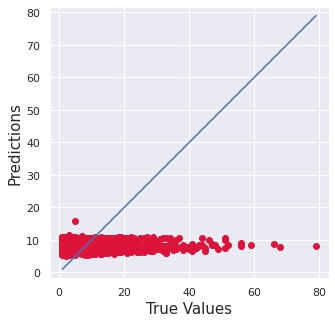

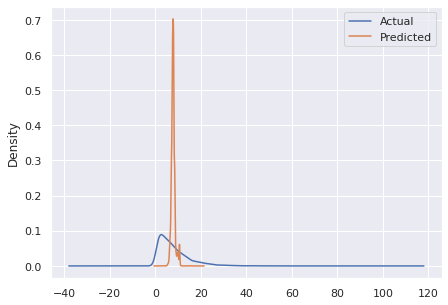

In [89]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

params = {'n_estimators': 350,
          'max_depth': 4,
          'min_samples_split': 5,
          'learning_rate': 0.01,
          'loss': 'ls'}
reg = GradientBoostingRegressor(**params)
reg.fit(X_train, Y_train)
Y_pred = reg.predict(X_test)


print('Mean Absolute Error :',mean_absolute_error(Y_test,Y_pred))
print('Mean Squared Error :',mean_squared_error(Y_test,Y_pred))
print('r2 score :',r2_score(Y_test,Y_pred))

plt.figure(figsize=(5,5))
plt.scatter(Y_test, Y_pred, c='crimson')

p1 = max(max(Y_pred), max(Y_test))
p2 = min(min(Y_pred), min(Y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

pd.DataFrame({'Actual': np.array(Y_test),'Predicted':np.array(Y_pred)}).plot(kind='kde')
mae_scores['gradient'] = mean_absolute_error(Y_test,Y_pred)
mse_scores['gradient'] = mean_squared_error(Y_test,Y_pred)
r2_scores['gradient'] = r2_score(Y_test,Y_pred)

Random Forest Regressor

Mean Absolute Error : 5.598691629492248
Mean SquaredError : 59.77707794578441
r2 score : -0.19999743103425893


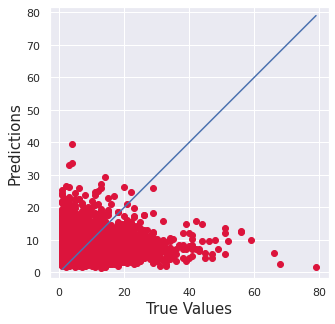

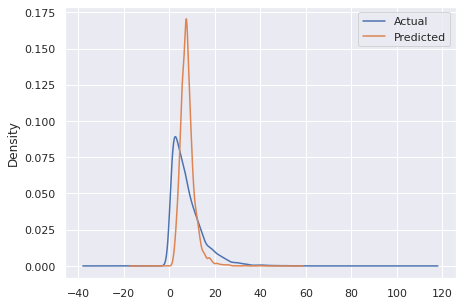

In [90]:

rf_regr = RandomForestRegressor().fit(X_train, Y_train)
Y_pred = rf_regr.predict(X_test)

print('Mean Absolute Error :',mean_absolute_error(Y_test,Y_pred))
print('Mean SquaredError :',mean_squared_error(Y_test,Y_pred))
print('r2 score :',r2_score(Y_test,Y_pred))


plt.figure(figsize=(5,5))
plt.scatter(Y_test, Y_pred, c='crimson')

p1 = max(max(Y_pred), max(Y_test))
p2 = min(min(Y_pred), min(Y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

pd.DataFrame({'Actual': np.array(Y_test),'Predicted':np.array(Y_pred)}).plot(kind='kde')

mae_scores['random'] = mean_absolute_error(Y_test,Y_pred)
mse_scores['random'] = mean_squared_error(Y_test,Y_pred)
r2_scores['random'] = r2_score(Y_test,Y_pred)

Neural Network

In [91]:
model = Sequential()
model.add(Dense(30, input_dim=17, activation='relu', kernel_initializer='normal'))
model.add(Dense(10, kernel_initializer='normal'))
model.add(Dense(1, kernel_initializer='normal'))
model.compile(loss='mae', optimizer='adam' ,metrics=['mse','mean_absolute_error'])

In [92]:
history = model.fit(X_train, Y_train, epochs=250, batch_size=1000 )

Epoch 1/250
19/19 [==============================] - 0s 2ms/step - loss: 7.8514 - mse: 107.2520 - mean_absolute_error: 7.8514
Epoch 2/250
19/19 [==============================] - 0s 2ms/step - loss: 7.7106 - mse: 105.4144 - mean_absolute_error: 7.7106
Epoch 3/250
19/19 [==============================] - 0s 3ms/step - loss: 7.6115 - mse: 103.8583 - mean_absolute_error: 7.6115
Epoch 4/250
19/19 [==============================] - 0s 2ms/step - loss: 7.0811 - mse: 95.9106 - mean_absolute_error: 7.0811
Epoch 5/250
19/19 [==============================] - 0s 2ms/step - loss: 6.1511 - mse: 82.4444 - mean_absolute_error: 6.1511
Epoch 6/250
19/19 [==============================] - 0s 3ms/step - loss: 5.2344 - mse: 62.8333 - mean_absolute_error: 5.2344
Epoch 7/250
19/19 [==============================] - 0s 2ms/step - loss: 5.0306 - mse: 54.3453 - mean_absolute_error: 5.0306
Epoch 8/250
19/19 [==============================] - 0s 2ms/step - loss: 5.0095 - mse: 53.0290 - mean_absolute_error: 5.00

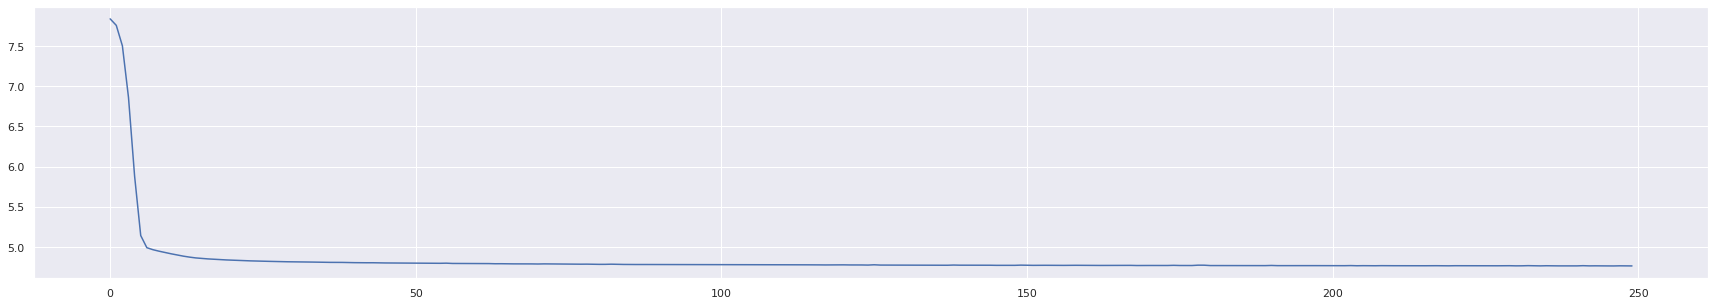

In [93]:
from matplotlib import pyplot

pyplot.figure(figsize=(30, 5))
pyplot.plot(history.history['mean_absolute_error'])
pyplot.show()

In [94]:
Y_pred = model.predict(X_test)
Y_pred = Y_pred.reshape(len(Y_pred))
Y_pred

array([6.508354 , 5.152036 , 6.629171 , ..., 5.6665936, 6.586874 ,
       8.1605425], dtype=float32)

In [95]:
d = {'Actual' : np.array(Y_test), 'Predicted':Y_pred}
output = pd.DataFrame(d)

In [96]:
output

,Actual,Predicted
0,11,6.508354
1,13,5.152036
2,12,6.629171
3,5,5.291212
4,15,6.387793
...,...,...
6145,2,5.337941
6146,21,5.532217
6147,16,5.666594
6148,1,6.586874


In [97]:

print('Mean Absolute Error :',mean_absolute_error(Y_test,Y_pred))
print('Mean SquaredError :',mean_squared_error(Y_test,Y_pred))
print('r2 score :',r2_score(Y_test,Y_pred))

mae_scores['neural'] = mean_absolute_error(Y_test,Y_pred)
mse_scores['neural'] = mean_squared_error(Y_test,Y_pred)
r2_scores['neural'] = r2_score(Y_test,Y_pred)

Mean Absolute Error : 4.892311325344613
Mean SquaredError : 52.958156035890106
r2 score : -0.06311070027572674


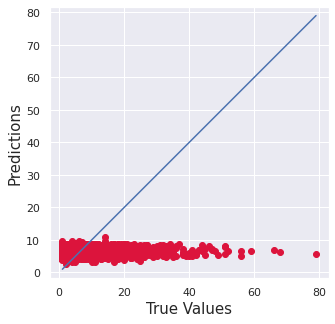

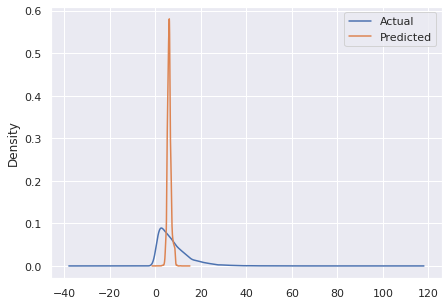

In [98]:
plt.figure(figsize=(5,5))
plt.scatter(Y_test, Y_pred, c='crimson')

p1 = max(max(Y_pred), max(Y_test))
p2 = min(min(Y_pred), min(Y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

pd.DataFrame({'Actual': np.array(Y_test),'Predicted':np.array(Y_pred)}).plot(kind='kde')


In [99]:
print('mae scores : ',mae_scores)
print('mse scores : ',mse_scores)
print('r2 scores : ',r2_scores)

mae scores :  {'linear': 5.062200311250608, 'svm': 4.903883973052011, 'decision': 6.072584505905288, 'gradient': 5.073980502929229, 'random': 5.598691629492248, 'neural': 4.892311325344613}
mse scores :  {'linear': 49.25310730075614, 'svm': 53.45969723545348, 'decision': 73.61936196277009, 'gradient': 49.28925551021683, 'random': 59.77707794578441, 'neural': 52.958156035890106}
r2 scores :  {'linear': 0.01126645425915862, 'svm': -0.07317890989245868, 'decision': -0.47787493577101925, 'gradient': 0.010540795528755864, 'random': -0.19999743103425893, 'neural': -0.06311070027572674}


In [100]:
model_names = ['linear Regression','Decision Tree','Random Forest','Gradient Boosting','SVM','Neural Network']
Mae_scores_list = [round(mae_scores['linear'],2),round(mae_scores['decision'],2),round(mae_scores['random'],2),round(mae_scores['gradient'],2),round(mae_scores['svm'],2),round(mae_scores['neural'],2)]
Mse_scores_list = [round(mse_scores['linear'],2),round(mse_scores['decision'],2),round(mse_scores['random'],2),round(mse_scores['gradient'],2),round(mse_scores['svm'],2),round(mse_scores['neural'],2)]
r2_scores_list = [round(r2_scores['linear'],2),round(r2_scores['decision'],2),round(r2_scores['random'],2),round(r2_scores['gradient'],2),round(r2_scores['svm'],2),round(r2_scores['neural'],2)]

In [101]:
scores = pd.DataFrame(np.array([model_names, Mae_scores_list, Mse_scores_list, r2_scores_list])).transpose().rename(columns={0:'Models',1:'MAE',2:'MSE',3:'r2 score'})

In [102]:
scores

,Models,MAE,MSE,r2 score
0,linear Regression,5.06,49.25,0.01
1,Decision Tree,6.07,73.62,-0.48
2,Random Forest,5.6,59.78,-0.2
3,Gradient Boosting,5.07,49.29,0.01
4,SVM,4.9,53.46,-0.07
5,Neural Network,4.89,52.96,-0.06


# Generate Pickle File

In [103]:
pickle.dump(random_forest_classifier, open('covid_classification.pkl', 'wb'))
pickle.dump(scaler, open('covid_scaler.pkl', 'wb'))
model.save("covid_regression.hdf5")

#Visuaization

Feature wise Mortality prediction

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn

Text(0.5, 0, 'Fatality rate: 15.64 %')

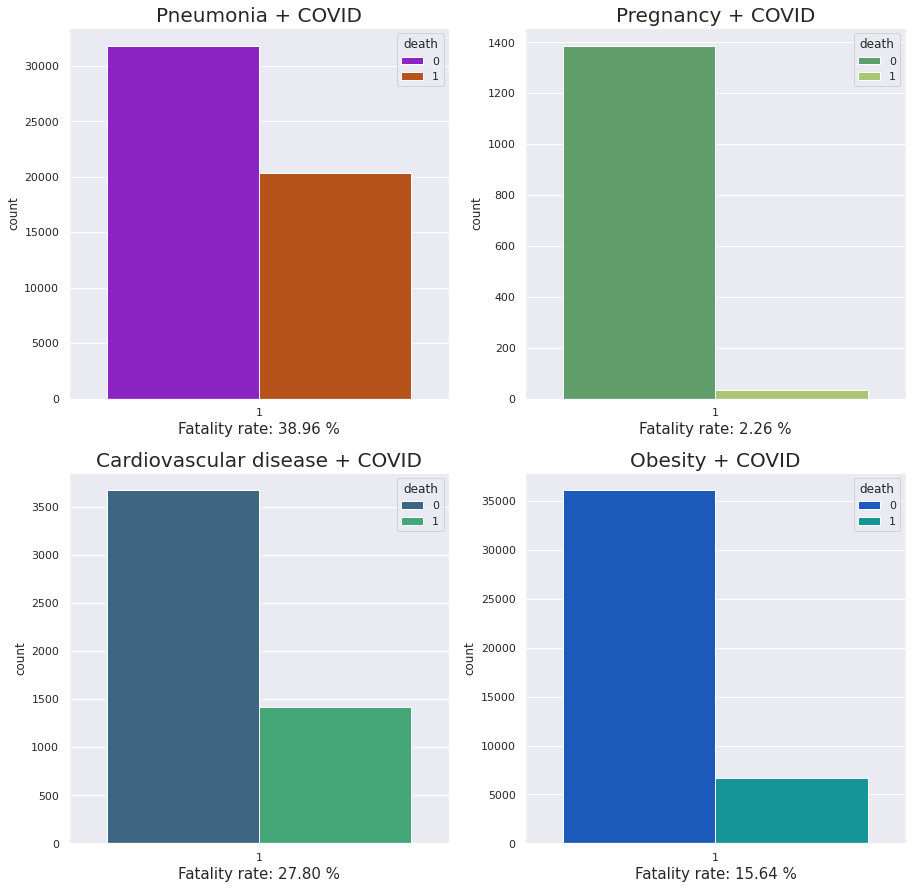

In [104]:
fig2=plt.figure(figsize=(15,15))
ax1=fig2.add_subplot(2,2,1)
ax2=fig2.add_subplot(2,2,2)
ax3=fig2.add_subplot(2,2,3)
ax4=fig2.add_subplot(2,2,4)
df_pneu=positive_patients[positive_patients['pneumonia']==1]
df_preg=positive_patients[positive_patients['pregnancy']==1]
df_card=positive_patients[positive_patients['cardiovascular']==1]
df_obes=positive_patients[positive_patients['obesity']==1]

sb.countplot('pneumonia',data=df_pneu,hue='death',ax=ax1,palette='gnuplot')
sb.countplot('pregnancy',data=df_preg,hue='death',ax=ax2,palette='summer')
sb.countplot('cardiovascular',data=df_card,hue='death',ax=ax3,palette='viridis')
sb.countplot('obesity',data=df_obes,hue='death',ax=ax4,palette='winter')

ax1.set_title('Pneumonia + COVID',size=20)
ax2.set_title('Pregnancy + COVID',size=20)
ax3.set_title('Cardiovascular disease + COVID',size=20)
ax4.set_title('Obesity + COVID',size=20)

ax1.set_xlabel('Fatality rate: {0:.2f} %'.format(100*df_pneu['death'].value_counts()[1]/df_pneu['death'].shape[0]),size=15)

ax2.set_xlabel('Fatality rate: {0:.2f} %'.format(100*df_preg['death'].value_counts()[1]/df_preg['death'].shape[0]),size=15)

ax3.set_xlabel('Fatality rate: {0:.2f} %'.format(100*df_card['death'].value_counts()[1]/df_card['death'].shape[0]),size=15)

ax4.set_xlabel('Fatality rate: {0:.2f} %'.format(100*df_obes['death'].value_counts()[1]/df_obes['death'].shape[0]),size=15)

Age wise mortality prediction

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'COVID +ve case fatality with respect to age groups')

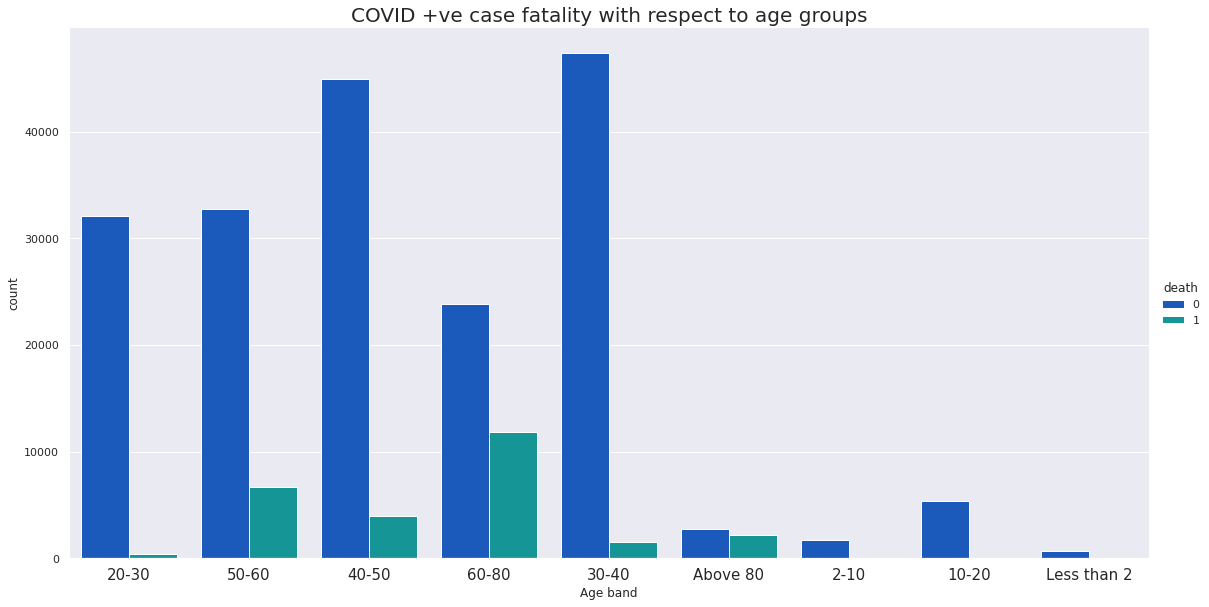

In [105]:
def age_band(age):
    
    if age<2:
        return 'Less than 2'
    elif (age>1) and (age<11):
        return '2-10'
    elif (age>10 and age<21):
        return '10-20'
    elif (age>20 and age<31):
        return '20-30'
    elif (age>30 and age<41):
        return '30-40'
    elif (age>40 and age<51):
        return '40-50'
    elif (age>50 and age<61):
        return '50-60'
    elif (age>60 and age<81):
        return '60-80'
    else:
        return 'Above 80'

positive_patients['Age band']=positive_patients['age'].apply(age_band)

sb.catplot('Age band',kind='count',hue='death',data=positive_patients,height=8,aspect=2,palette='winter')
plt.xticks(size=15)
plt.title('COVID +ve case fatality with respect to age groups',size=20)

# Classification based on features selected by Paper

In [106]:
target='death'
X = positive_patients_oversampled[['age','sex','intubated','pneumonia','copd']]
Y = positive_patients_oversampled[target]
X,Y = shuffle(X,Y)
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.25,random_state=12)

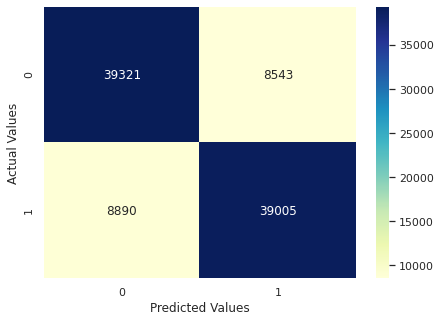

Precision:  0.8203289307647009
Recall:  0.8143856352437624
F1-score:  0.8173464790503232


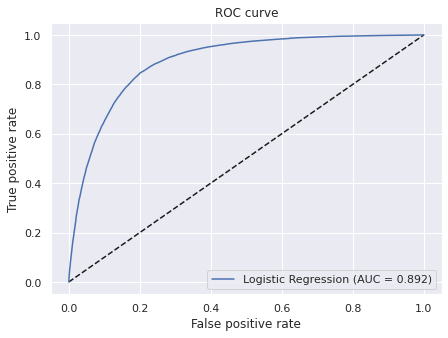

In [107]:
logistic_regression = LogisticRegression(max_iter=200)
logistic_regression.fit(X_train,Y_train)
Y_pred_logistic_prob=logistic_regression.decision_function(X_test)
Y_pred_logistic_prob.reshape(len(Y_pred_logistic_prob))

Y_pred_logistic = logistic_regression.predict(X_test)

confusion_matrix = pd.crosstab(Y_test, Y_pred_logistic, rownames=['Actual Values'], colnames=['Predicted Values'])
sb.heatmap(confusion_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

print('Precision: ',metrics.precision_score(Y_test, Y_pred_logistic))
print('Recall: ',metrics.recall_score(Y_test, Y_pred_logistic))
print('F1-score: ',metrics.f1_score(Y_test, Y_pred_logistic))

fpr_logistic, tpr_logistic, thresholds_logistic = roc_curve(Y_test, Y_pred_logistic_prob)
auc_logistic = auc(fpr_logistic, tpr_logistic)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_logistic, tpr_logistic, label='Logistic Regression (AUC = {:.3f})'.format(auc_logistic))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [108]:
target='death'
X = positive_patients_undersampled[['age','sex','diabetes','pneumonia','copd']]
Y = positive_patients_undersampled[target]
X,Y = shuffle(X,Y)
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.25,random_state=12)

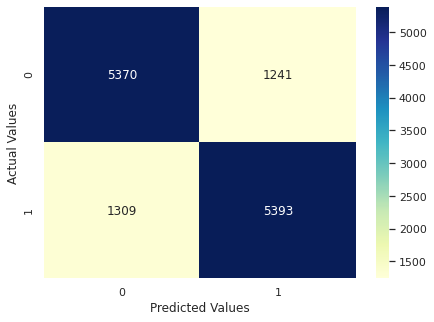

Precision:  0.8129333735302985
Recall:  0.8046851686063862
F1-score:  0.8087882423515297


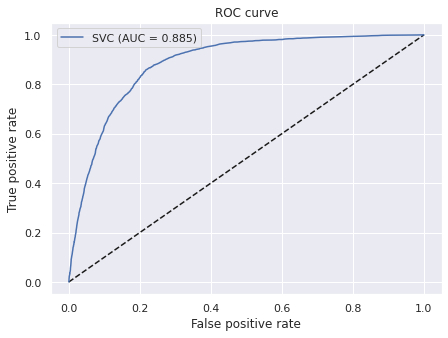

In [109]:
svc = SVC()
svc.fit(X_train,Y_train)
Y_pred_svc_prob=svc.decision_function(X_test)
Y_pred_svc_prob.reshape(len(Y_pred_svc_prob))

Y_pred_svc = svc.predict(X_test)

confusion_matrix = pd.crosstab(Y_test, Y_pred_svc, rownames=['Actual Values'], colnames=['Predicted Values'])
sb.heatmap(confusion_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

print('Precision: ',metrics.precision_score(Y_test, Y_pred_svc))
print('Recall: ',metrics.recall_score(Y_test, Y_pred_svc))
print('F1-score: ',metrics.f1_score(Y_test, Y_pred_svc))

fpr_svc, tpr_svc, thresholds_svc = roc_curve(Y_test, Y_pred_svc_prob)
auc_svc = auc(fpr_svc, tpr_svc)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_svc, tpr_svc, label='SVC (AUC = {:.3f})'.format(auc_svc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [110]:
target='death'
X = positive_patients_undersampled[['age','intubated','diabetes','pneumonia','hypertension']]
Y = positive_patients_undersampled[target]
X,Y = shuffle(X,Y)
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.25,random_state=12)

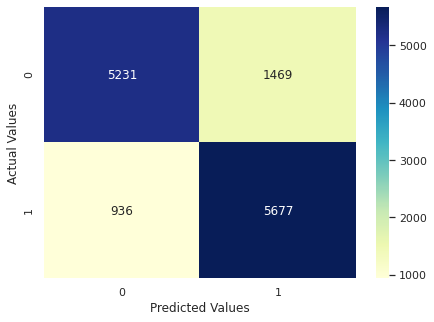

Precision:  0.7944304506017352
Recall:  0.8584606078935431
F1-score:  0.8252053201540809


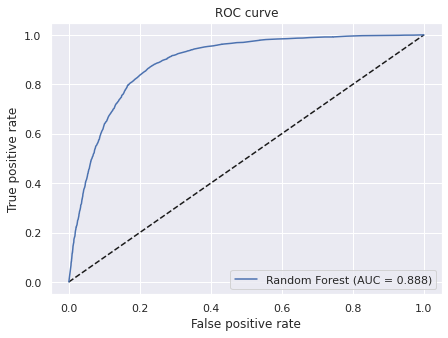

In [111]:
random_forest_classifier = RandomForestClassifier()
random_forest_classifier.fit(X_train,Y_train)
Y_pred_forest = random_forest_classifier.predict(X_test)

Y_pred_forest_prob = random_forest_classifier.predict_proba(X_test)

confusion_matrix = pd.crosstab(Y_test, Y_pred_forest, rownames=['Actual Values'], colnames=['Predicted Values'])
sb.heatmap(confusion_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

print('Precision: ',metrics.precision_score(Y_test, Y_pred_forest))
print('Recall: ',metrics.recall_score(Y_test, Y_pred_forest))
print('F1-score: ',metrics.f1_score(Y_test, Y_pred_forest))


fpr_forest, tpr_forest, thresholds_forest = roc_curve(Y_test, Y_pred_forest_prob[:,1])
auc_forest = auc(fpr_forest, tpr_forest)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_forest, tpr_forest, label='Random Forest (AUC = {:.3f})'.format(auc_forest))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()